In [2]:
from google.colab import drive
drive.mount('/content/drive/')
prefix = './drive/My Drive/ND_CSE/Year_1/Research:Care-Net/JBDF_CareNet/Care-Net Backend/code_and_data'
!echo "Project dir contents:" && ls "$prefix/"
!echo -e "\nColab Notebook home dir:" && ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Project dir contents:
 211_IN_Data_Parsing.ipynb	   Prepare_dataset.ipynb
 binder				   README.md
 data				  'Recommendation: deep_only.ipynb'
 demos				  'Recommendation: wide_and_deep_model.ipynb'
 embeddings			  'Recommendation: wide_only.ipynb'
 embed_serv_sim_search.ipynb	   semantic_embeddings_cluster_plot.ipynb
 figures			   service_embeddings_UMAP.ipynb
 Graph_Data_Extraction.ipynb	   USE_embeddings.ipynb
 models				   USE_embed_serv_sim_search.ipynb
 Node_Text_Embedding_sBERT.ipynb

Colab Notebook home dir:
drive  sample_data



## Process Ref dataset

Use data to see how services are referred together (eg for client c1, 211 referred c1 to services \{s1,s2,s3,...})

In [3]:
!pip3 install h2o4gpu pgeocode

     |████████████████████████████████| 332.8MB 47kB/s 
     |████████████████████████████████| 6.7MB 7.4MB/s 
     |████████████████████████████████| 614kB 52.2MB/s 
     |████████████████████████████████| 450kB 56.3MB/s 
     |████████████████████████████████| 501kB 56.3MB/s 
  Created wheel for psutil: filename=psutil-5.7.0-cp36-cp36m-linux_x86_64.whl size=272668 sha256=6e9bdc62a5e2ce0bc34187d09fa1e7b14f8030e20867fcbe71b629d8f18341ac
  Stored in directory: /root/.cache/pip/wheels/d7/69/b4/3200b95828d1f0ddb3cb5699083717f4fdbd9b4223d0644c57
  Created wheel for tornado: filename=tornado-6.0.4-cp36-cp36m-linux_x86_64.whl size=427636 sha256=8043c46d80658ac26091440ed22f31e2c11322ebef7d20d663e037d5dc057a02
  Stored in directory: /root/.cache/pip/wheels/93/84/2f/409c7b2bb3afc3aa727f7ee8787975e0793f74d1165f4d0104
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=cbdc9a0368416e8d2325d42e5a8606c4fedd2ada01d3299aa5e0d2f14f1e85c4
  Stored in directory: /root/.c

In [0]:
import pandas as pd
import json
import csv
import pickle
import numpy as np
import os
from tqdm import tqdm
from h2o4gpu.metrics.pairwise import cosine_similarity
import pgeocode
import tensorflow_hub as hub
import datetime
import random
import ast
import multiprocessing

In [0]:
 # download auxillary data
with open(prefix + '/data/services_nodes.json') as sn:
    serv_nodes = json.loads(sn.read())
    
# with open(prefix + '/data/services_edgelist.csv') as se:
#     serv_edges = csv.reader(se)

# TODO: refacto var name to something more accurate and general
with open(prefix + '/data/HIN_nodes.json') as taxo:
    hin_nodes = json.loads(taxo.read())

with open(prefix + '/data/service_id_to_node_num.json') as sn:
    serv_trans = json.loads(sn.read())

with open(prefix + '/data/code_to_node_num.json') as ct:
    code_trans = json.loads(ct.read())

# load queries file
queries_path = os.path.join(prefix, 'data', 'HIN_references.csv')
with open(queries_path) as qf:
  queries = qf.read()
  queries = queries.split(',')
  # cleanup some bad data. TODO: Fix in notebook that generates the data
  queries = [''] + [q for q in queries if q != '']

tagged_texts = {}

if os.path.exists(os.path.join(prefix, 'data', 'tagged_texts.json')):
  with open(os.path.join(prefix, 'data', 'tagged_texts.json')) as ttf:
    tagged_texts = json.load(ttf)

In [6]:
col_names = ['InteractionReferral_ReferralsModule_client_id', 'InteractionReferral_ReferralsModule_id',	
             'InteractionReferralSite_Site_id', 'InteractionReferral_ReferralsModule_field_config_id', 
             'InteractionReferralSite_Site_name', 'InteractionReferralService_Service_id', 
             'InteractionReferral_ReferralsModule_create_stamp', 'InteractionReferralService_Service_name', 
             'InteractionReferralTaxonomy_Taxonomy_id', 'InteractionReferral_ReferralsModule_edit_stamp', 
             'InteractionReferralTaxonomy_Taxonomy_name', 'InteractionReferral_ReferralsModule_audit_stamp',
             'InteractionReferral_ReferralsModule_interaction_id', 'InteractionReferralTaxonomy_Taxonomy_code', 
             'InteractionReferral_ReferralsModule_referral_status_accepted', 'InteractionReferralTaxonomy_Taxonomy_linked_taxonomy_id',
             'InteractionReferral_ReferralsModule_referral_status_provided', 'InteractionReferralTaxonomy_Taxonomy_linked_taxonomy_term',
             'InteractionReferral_ReferralsModule_referral_status_referred', 'InteractionReferralTaxonomy_Taxonomy_linked_taxonomy_code',
             'InteractionReferralTaxonomy_Taxonomy_reason_unmet', 'InteractionReferral_ReferralsModule_referral_status_requested', 
             'InteractionReferralTaxonomy_Taxonomy_external_reference_name', 'InteractionReferral_ReferralsModule_date_of_referral', 
             'InteractionReferralTaxonomy_Taxonomy_external_reference_code', 'InteractionReferral_ReferralsModule_date_of_service_provided',
             'InteractionReferral_ReferralsModule_units', 'InteractionReferral_ReferralsModule_amount'
             ]

#           a  b  c  d  e  f  g  h  i  j  k  l  m  n  o  p  q  r  s  t  u  v  w  x  y  z  aa bb 
col_mask = [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0 ,0, 0]
new_names = [
             'ref_client_id', 'ref_id', 'site_id', 'serv_id', 'taxo_id', 'timestamp',
             'ref_unmet_id',  'taxo_code', 'taxo_link_id', 'taxo_link', 'taxo_link_codes',
             'ref_unmet', 'taxo_alt_name', 'taxo_alt_code'
            ]

NODE_TYPE = 'services'
BATCH_SIZE = 256
NUM_NODES = len(serv_nodes.keys())
NUM_BATCHES =  NUM_NODES // BATCH_SIZE

MODEL = 'USE'
# MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
# MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/2'
MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'
MODEL_TYPE = MODEL_URL.split('/')[-2]
MODEL_VER = MODEL_URL.split('/')[-1]

!mkdir -p "$prefix/embeddings/$MODEL/"
print("Using Model {}_{}_v{}".format(MODEL, MODEL_TYPE, MODEL_VER))

Using Model USE_universal-sentence-encoder_v4


In [7]:
# fetch the embeddings of the social services for our dataset later
tagged_embeds = {}
embed_path = os.path.join(prefix, 'embeddings', MODEL, "{}_{}_v{}.pkl".format(
    NODE_TYPE, MODEL_TYPE, MODEL_VER
    ))
if os.path.exists(embed_path):
  print("Loading embeddings from {}".format(embed_path))
  with open(embed_path, 'rb') as f:
        tagged_embeds = pickle.load(f)

Loading embeddings from ./drive/My Drive/ND_CSE/Year_1/Research:Care-Net/JBDF_CareNet/Care-Net Backend/code_and_data/embeddings/USE/services_universal-sentence-encoder_v4.pkl


In [0]:
# load and merge our service references data
refs_path1 = prefix + '/data/Referrals_jan-june.xlsx'
refs_path2 = prefix + '/data/Referrals_july-dec.xlsx'

# read the multiple service reference files
refs_df = pd.DataFrame()
refs_df1 = refs_df.append(pd.read_excel(refs_path1, sheet_name='Interaction_referral'), ignore_index=True)
refs_df2 = pd.read_excel(refs_path2, sheet_name='Interaction_referral')
# temp fix because google drive isn't updating a file
refs_df1.columns = refs_df2.columns
refs_df = refs_df1.append(refs_df2)

In [9]:
# filter and modify the column names to something more friendly and meaningful
if list(refs_df.columns) == col_names:
    sel_cols = [col for i, col in enumerate(col_names) if col_mask[i]]
    refs_df = refs_df[sel_cols]
    refs_df.columns = new_names
    print(refs_df.columns)

Index(['ref_client_id', 'ref_id', 'site_id', 'serv_id', 'taxo_id', 'timestamp',
       'ref_unmet_id', 'taxo_code', 'taxo_link_id', 'taxo_link',
       'taxo_link_codes', 'ref_unmet', 'taxo_alt_name', 'taxo_alt_code'],
      dtype='object')


In [10]:
# each key is a servID and its value is a list of servIDs that got referred along side it
service_refs = {}
neg_refs = {}
refs_df = refs_df.replace(np.nan, '', regex=True)

pbar = tqdm(list(refs_df['serv_id']),mininterval=0.9)
pbar.set_description('Parsing references...')

# go through each reference (ref_client_id) and save which services were
# referred together throughout the data
def parse_ref_links(row):
    ref_client_id, serv_id, ref_unmet = row
    # ref_unmet = '' if not ref_unmet else ref_unmet
    if ref_unmet != '':
        # keep track of which refs and services were rejected 
        neg_refs[ref_client_id] = [] if ref_client_id not in neg_refs else neg_refs[ref_client_id] + [serv_id]
    # elif ref_client_id not in :
    else:
        service_refs[ref_client_id] = [] if ref_client_id not in service_refs else service_refs[ref_client_id] + [serv_id]
    global pbar
    pbar.update(1)
    return row
        
# copy the referrals between services and capture any explicit negative samples 
serv_refs = refs_df[['ref_client_id', 'serv_id', 'ref_unmet']]
serv_refs.apply(parse_ref_links, axis=1)
# refs_df[['ref_client_id', 'serv_id', 'ref_unmet']]

Parsing references...: 100%|█████████▉| 265978/266155 [00:22<00:00, 12701.81it/s]

,ref_client_id,serv_id,ref_unmet
0,104236,100,
1,134474,100,
2,141496,100,
3,146813,100,
4,158667,100,
...,...,...,...
127991,430798,2244,
127992,430807,7029,
127993,430810,13128,
127994,430819,13128,


In [11]:
# get a matrix of the cosine similarity of every pair of elements 
# if the pair's similarity meets the threshold theta,
# then add it as a "reference"
measure_fn = cosine_similarity
theta = 0.7

embeds = [tagged_embeds[k]['embed'] for k in tagged_embeds]
serv_ids = list(serv_trans.keys())
sim_servs = {}
sim_mtx = cosine_similarity(embeds)
pbar = tqdm(embeds, mininterval=10, desc='Linking similar services')
for i in range(len(embeds)):
    for j in range(len(embeds)):
        sim = sim_mtx[i][j]
        serv1 = serv_ids[i]
        serv2 = serv_ids[j]
        # only add services that meet the threshold and make
        # sure you don't add yourself
        if sim > theta and serv1 != serv2:
            sim_servs[serv1] = [] if serv1 not in sim_servs else sim_servs[serv1] + [serv2]
    pbar.update(1)


Parsing references...: : 266156it [00:40, 12701.81it/s]                          
Linking similar services:  99%|█████████▉| 16462/16547 [08:12<00:02, 33.70it/s]

In [12]:
# track services that were explicitly referred together
# ref_servs <- servs known to be referred together
ref_servs = {}

# keep track of services that are linked via shared taxonomy codes (2-step neighbors):
# ie service1 <-> code1 <-> code2 <-> 
# rel_servs <- servs rel by taxo code (1-hop neighbors in the taxonomy graph)
rel_servs = {}

# for every code_servs[c] where c is a 211 taxonomy code,
# save the services that have been labeled with c
code_servs = {}

pbar = tqdm(service_refs, mininterval=1.5, desc='Linking referred and related services.')
for i, ref in enumerate(service_refs):
    servs = service_refs[ref]
    for j, serv in enumerate(servs):
        
        # checked and some services are not in the provided IN 211 services data
        if serv not in serv_trans:
            continue
        if serv not in rel_servs:
            nid = serv_trans[serv]
            # TODO: make this less messy or move elsewhere
            # save the services that are related to serv via shared codes
            serv_node = hin_nodes[nid]
            codes = serv_node['codes']
            # codes = hin_nodes[str(code_nid)]['related']
            for c in codes:
                rels = []
                if c not in code_servs:
                    # print(1)
                    code_servs[c] = []
                    for node_num, s_node in serv_nodes.items():
                        sid = s_node['serv_id']
                        if 'codes' in s_node and c in s_node['codes']:
                            rels.append(sid)
                    code_servs[c] = list(set(code_servs[c] + [serv] + rels))
                rels = code_servs[c]
                rel_servs[serv] = rels
        
        # avoid copy by ref
        tmp = servs[::]
        if serv not in ref_servs:
            tmp.remove(serv)
            ref_servs[serv] = tmp 
        else:
            tmp.remove(serv)
            ref_servs[serv] = ref_servs[serv] + tmp
    pbar.update(1)

ref_sum = sum(list(map(lambda r: len(ref_servs[r]), ref_servs)))
ref_avg = ref_sum/len(ref_servs)
print("\nref_servs: There are {} services linked by reference with an avg of {} references per service.".format(
    len(ref_servs), ref_avg))
rel_avg = sum(list(map(lambda r: len(rel_servs[r]), rel_servs)))/len(rel_servs)
print("rel_servs: There are {} services linked by taxonomy code relations with an avg of {} references per service.".format(
    len(rel_servs), rel_avg))
sim_avg = sum(list(map(lambda r: len(sim_servs[r]), sim_servs)))/len(sim_servs)
print("sim_servs: There are {} services linked by cosine similarity thresholding with an avg of {} references per service.".format(
    len(sim_servs), sim_avg))



Linking referred and related services.:   0%|          | 0/100784 [00:00<?, ?it/s]

Linking referred and related services.:   2%|▏         | 1696/100784 [00:01<01:27, 1128.37it/s]

Linking referred and related services.:  26%|██▌       | 25884/100784 [00:03<00:47, 1565.00it/s]


ref_servs: There are 6382 services linked by reference with an avg of 75.36023190222501 references per service.
rel_servs: There are 6371 services linked by taxonomy code relations with an avg of 105.46052425051012 references per service.
sim_servs: There are 16301 services linked by cosine similarity thresholding with an avg of 128.5368382307834 references per service.


There are 14259 services with queries
Each service has an avg of 5.045567172297093, a median of 3.0, and variance of 30.488647026777542


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


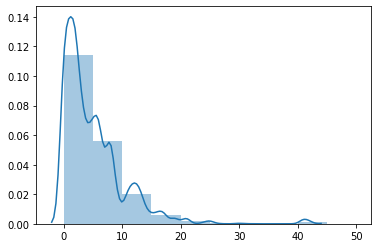

In [13]:
# get some basic stats about the number of keywords/queries for each service

q_lens = {}
serv_qs = {}
for nid in serv_nodes:
    node = serv_nodes[nid]
    
    sid = node['serv_id']
    serv_qs[sid] = []
    q_len = 0
    for code in node['codes']:
        code_node = hin_nodes[str(code_trans[code])]
        # print(code_node.keys())
        if 'keywords' not in code_node:
            continue
        # print(1)
        serv_qs[sid] = serv_qs[sid] + code_node['keywords']
        q_len += len(code_node['keywords'])
    q_lens[sid] = q_len
print("There are {} services with queries".format(sum([1 for q in q_lens if q_lens[q]])))
q_lens = list(q_lens.values())
print("Each service has an avg of {}, a median of {}, and variance of {}".format(
    np.mean(q_lens), np.median(q_lens), np.var(q_lens)
))
import seaborn as sns
sns.distplot(q_lens, bins=list(range(0,51,5)), label="Distribution of number of queries per service")

## Create Remaining Dataset Columns

In [14]:
ref_feats = refs_df[['ref_id', 'site_id', 'serv_id', 'timestamp',]]

serv_recs = {}
pbar = tqdm(list(serv_trans.keys()), mininterval=15, desc="Creating rec vectors...")
poss = []
negs = []

# for every service
for i, sid in enumerate(serv_trans):
    # recs = []
    recs = [0 for s in serv_trans]
    # for every service
    for j, s in enumerate(serv_trans):

        # if the "selected" (first: sid) service_id 
        if sid in ref_servs:
            # see if the "candidate" service (second: s)
            #  has been referred alongside the "selected" service
            s1 = set(ref_servs[sid])
            if s in s1:
                recs[j] = 1
        elif sid in rel_servs:
            # see if the "candidate" service (second: s)
            #  is related to "selected" service (via shared taxonomy codes)
            s2 = set(rel_servs[sid])
            if s in s2:
                recs[j] = 1
        elif sid in sim_servs:
            s3 = set(sim_servs[sid])
            # see if candidate service meets similarity threshold
            # to be related to selected servicee
            if s in s3:
                recs[j] = 1
        # else:
        #     recs.append(0)

    serv_recs[sid] = recs
    pos = sum(recs)
    neg = len(recs) - pos
    poss.append(pos)
    negs.append(neg)

    if i % 1000 == 0:
        avg_pos = sum(poss)/len(poss)
        avg_neg = sum(negs)/len(negs)
        print("avg positive recs: {} ---- negative recs: {}".format(avg_pos, avg_neg))
    pbar.update()




Creating rec vectors...:   0%|          | 0/16547 [00:00<?, ?it/s]

avg positive recs: 106.0 ---- negative recs: 16441.0



Linking similar services: 100%|██████████| 16547/16547 [08:27<00:00, 33.70it/s]


Creating rec vectors...:   4%|▎         | 620/16547 [00:15<06:25, 41.27it/s]

Linking referred and related services.: 100%|██████████| 100784/100784 [00:22<00:00, 1565.00it/s]

avg positive recs: 60.2007992007992 ---- negative recs: 16486.7992007992





Creating rec vectors...:   6%|▋         | 1068/16547 [00:28<06:15, 41.27it/s]


Creating rec vectors...:   7%|▋         | 1113/16547 [00:30<06:42, 38.32it/s]


Creating rec vectors...:  10%|▉         | 1612/16547 [00:45<06:47, 36.64it/s]

avg positive recs: 70.07546226886556 ---- negative recs: 16476.924537731134





Creating rec vectors...:  13%|█▎        | 2121/16547 [00:58<06:33, 36.64it/s]


Creating rec vectors...:  13%|█▎        | 2178/16547 [01:00<06:29, 36.90it/s]


Creating rec vectors...:  17%|█▋        | 2742/16547 [01:16<06:20, 36.30it/s]

avg positive recs: 73.04665111629457 ---- negative recs: 16473.953348883704





Creating rec vectors...:  20%|█▉        | 3279/16547 [01:28<06:05, 36.30it/s]


Creating rec vectors...:  20%|██        | 3371/16547 [01:31<05:49, 37.71it/s]


Creating rec vectors...:  24%|██▍       | 3943/16547 [01:48<05:47, 36.23it/s]


Creating rec vectors...:  24%|██▍       | 3943/16547 [01:48<05:47, 36.23it/s]

avg positive recs: 75.09972506873282 ---- negative recs: 16471.900274931268





Creating rec vectors...:  26%|██▌       | 4331/16547 [01:58<05:37, 36.23it/s]


Creating rec vectors...:  27%|██▋       | 4516/16547 [02:03<05:27, 36.79it/s]

avg positive recs: 73.8128374325135 ---- negative recs: 16473.187162567487





Creating rec vectors...:  30%|███       | 5027/16547 [02:18<05:13, 36.79it/s]


Creating rec vectors...:  30%|███       | 5028/16547 [02:18<05:20, 35.89it/s]


Creating rec vectors...:  32%|███▏      | 5281/16547 [02:28<05:13, 35.89it/s]


Creating rec vectors...:  33%|███▎      | 5486/16547 [02:33<05:24, 34.08it/s]

avg positive recs: 70.65105815697383 ---- negative recs: 16476.348941843025





Creating rec vectors...:  37%|███▋      | 6060/16547 [02:48<04:57, 35.21it/s]


Creating rec vectors...:  38%|███▊      | 6355/16547 [02:58<04:49, 35.21it/s]


Creating rec vectors...:  39%|███▉      | 6507/16547 [03:03<05:00, 33.39it/s]

avg positive recs: 70.70089987144694 ---- negative recs: 16476.29910012855





Creating rec vectors...:  43%|████▎     | 7052/16547 [03:18<04:38, 34.13it/s]


Creating rec vectors...:  44%|████▎     | 7239/16547 [03:29<04:32, 34.13it/s]


Creating rec vectors...:  45%|████▍     | 7426/16547 [03:33<04:57, 30.71it/s]


Creating rec vectors...:  47%|████▋     | 7797/16547 [03:49<05:06, 28.59it/s]


Creating rec vectors...:  47%|████▋     | 7797/16547 [03:49<05:06, 28.59it/s]

avg positive recs: 69.25546806649169 ---- negative recs: 16477.74453193351





Creating rec vectors...:  50%|████▉     | 8218/16547 [03:59<04:51, 28.59it/s]


Creating rec vectors...:  51%|█████     | 8396/16547 [04:04<04:20, 31.25it/s]


Creating rec vectors...:  54%|█████▍    | 8903/16547 [04:19<03:59, 31.90it/s]


Creating rec vectors...:  54%|█████▍    | 8903/16547 [04:19<03:59, 31.90it/s]

avg positive recs: 69.03855127208088 ---- negative recs: 16477.961448727918





Creating rec vectors...:  56%|█████▌    | 9244/16547 [04:29<03:48, 31.90it/s]


Creating rec vectors...:  57%|█████▋    | 9412/16547 [04:34<03:39, 32.48it/s]


Creating rec vectors...:  60%|█████▉    | 9905/16547 [04:49<03:24, 32.48it/s]


Creating rec vectors...:  60%|█████▉    | 9906/16547 [04:49<03:24, 32.54it/s]

avg positive recs: 72.05959404059594 ---- negative recs: 16474.940405959405





Creating rec vectors...:  62%|██████▏   | 10266/16547 [04:59<03:13, 32.54it/s]


Creating rec vectors...:  63%|██████▎   | 10454/16547 [05:04<03:01, 33.64it/s]

avg positive recs: 70.96191255340423 ---- negative recs: 16476.038087446595





Creating rec vectors...:  67%|██████▋   | 11054/16547 [05:19<02:35, 35.30it/s]


Creating rec vectors...:  69%|██████▉   | 11474/16547 [05:29<02:23, 35.30it/s]


Creating rec vectors...:  71%|███████   | 11678/16547 [05:34<02:11, 36.97it/s]

avg positive recs: 71.74293808849262 ---- negative recs: 16475.257061911507





Creating rec vectors...:  74%|███████▎  | 12187/16547 [05:49<01:57, 36.97it/s]


Creating rec vectors...:  74%|███████▎  | 12188/16547 [05:49<02:01, 35.90it/s]


Creating rec vectors...:  76%|███████▋  | 12639/16547 [05:59<01:48, 35.90it/s]


Creating rec vectors...:  78%|███████▊  | 12837/16547 [06:04<01:38, 37.83it/s]

avg positive recs: 70.0070763787401 ---- negative recs: 16476.99292362126





Creating rec vectors...:  81%|████████▏ | 13473/16547 [06:19<01:18, 39.01it/s]


Creating rec vectors...:  81%|████████▏ | 13473/16547 [06:19<01:18, 39.01it/s]


Creating rec vectors...:  84%|████████▎ | 13855/16547 [06:29<01:09, 39.01it/s]

avg positive recs: 70.31019212913364 ---- negative recs: 16476.689807870865





Creating rec vectors...:  85%|████████▌ | 14077/16547 [06:34<01:02, 39.37it/s]


Creating rec vectors...:  89%|████████▉ | 14712/16547 [06:49<00:45, 40.13it/s]

avg positive recs: 69.8951403239784 ---- negative recs: 16477.104859676023





Creating rec vectors...:  91%|█████████ | 15094/16547 [06:59<00:36, 40.13it/s]


Creating rec vectors...:  92%|█████████▏| 15238/16547 [07:04<00:34, 38.47it/s]


Creating rec vectors...:  97%|█████████▋| 15974/16547 [07:19<00:14, 38.47it/s]


Creating rec vectors...:  97%|█████████▋| 15975/16547 [07:19<00:13, 41.05it/s]

avg positive recs: 69.39635022811075 ---- negative recs: 16477.60364977189





Creating rec vectors...:  99%|█████████▊| 16337/16547 [07:29<00:05, 41.05it/s]


Creating rec vectors...:  99%|█████████▉| 16438/16547 [07:34<00:02, 37.34it/s]

In [15]:
fname = os.path.join(prefix, 'data', 'service_recommendations.json')
with open(fname, 'w') as f:
    json.dump(serv_recs, f)




Creating rec vectors...: 100%|██████████| 16547/16547 [07:50<00:00, 37.34it/s]

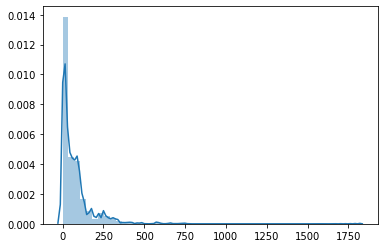

In [16]:
sns.distplot(poss, label="Distribution of number of positive recs per service")

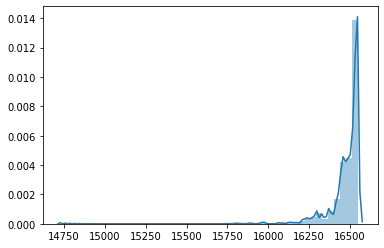

In [17]:
sns.distplot(negs, label="Distribution of number of negative recs per service")

In [18]:
# Load the TF-Hub module
print("Loading the TF-Hub {} module...".format(MODEL))
%time embed_fn = hub.load(MODEL_URL)
print("TF-Hub module is loaded.")

def extract_embed(queries):
    # Generates the embedding for the query
    query_embedding =  embed_fn(queries).numpy()
    # print(len(query_embedding))
    return query_embedding

Loading the TF-Hub USE module...
CPU times: user 11.6 s, sys: 3.22 s, total: 14.8 s
Wall time: 24.5 s
TF-Hub module is loaded.


In [19]:
# save query embeddings to speed up calculations below
tagged_q_embeds = {}
pbar = tqdm(queries, mininterval=5, desc='Embedding queries')
for query in queries:
    tagged_q_embeds[query] = extract_embed([query])
    pbar.update(1)





Embedding queries:   0%|          | 0/43950 [00:00<?, ?it/s]



Embedding queries:   2%|▏         | 809/43950 [00:05<04:26, 161.67it/s]



Embedding queries:   5%|▍         | 2112/43950 [00:10<03:49, 182.43it/s]



Embedding queries:   8%|▊         | 3438/43950 [00:15<03:21, 201.25it/s]



Embedding queries:  11%|█         | 4746/43950 [00:20<03:01, 216.20it/s]



Embedding queries:  13%|█▎        | 5928/43950 [00:25<02:51, 221.85it/s]



Embedding queries:  16%|█▌        | 7040/43950 [00:30<02:46, 221.95it/s]



Embedding queries:  18%|█▊        | 8085/43950 [00:35<02:45, 217.10it/s]



Embedding queries:  21%|██▏       | 9341/43950 [00:40<02:32, 226.29it/s]



Embedding queries:  24%|██▍       | 10555/43950 [00:45<02:24, 230.98it/s]



Embedding queries:  27%|██▋       | 11803/43950 [00:50<02:16, 236.26it/s]



Embedding queries:  30%|██▉       | 13030/43950 [00:55<02:09, 238.90it/s]



Embedding queries:  32%|███▏      | 14252/43950 [01:00<02:03, 240.52it/s]



Embedding queries

In [20]:
list(tagged_texts.values())[0]

['school district',
 'administers elementary middle high school school district',
 'provides student transportation service maintains information school location enrollment fee curriculum',
 'district provides information regarding special education service student age disability student transportation service',
 'program usually within formal education system operate school bus transport student school',
 'also included program issue voucher enable student use mean transportation school reimburse parent situation child served school transportation system school bus',
 'school bus service',
 'school district issued student bus pass',
 'school transportation program',
 'student transportation reimbursement',
 'student transportation voucher',
 'living within school district grade k']

In [0]:
n_samples = 0

filename = os.path.join(prefix, 'data', 'wide_deep_dataset_chkpnt.csv')
# keep text and convert/fetch during training to avoid absurd file size
feat_names = [
            'Distance',
            'Embedding_Similarity',
            'UNIX_Timestamp',
            'Selected_Text_Content',
            'Candidate_Text_Content', 
            'Previously_Recommended',
            'Query',
            'Label'
]
    
uniq_refs = list(set(list(serv_refs['serv_id'])))
in_sids = set(serv_ids)
uniq_refs = [ref for ref in uniq_refs if ref in in_sids]
sid_idxs = {}
for i, sid in enumerate(serv_ids):
    sid_idxs[sid] = i
nid_idxs = {}
for i, nid in enumerate(tagged_texts.keys()):
    nid_idxs[nid] = i

site_trans = {}
for nid, node in hin_nodes.items():
    if 'SITE_ID' in node:
        sid = str(node['SITE_ID'])
        site_trans[sid] = str(node['node_num'])
rows = [feat_names]


def create_dataset(data):

    # get the start and end index for this data chunk
    start = data[0][0]
    end = data[-1][0]
    prefix = './drive/My Drive/ND_CSE/Year_1/Research:Care-Net/JBDF_CareNet/Care-Net Backend/code_and_data'
    data_path = os.path.join(prefix, 'data', 'wide_deep_dataset_chunks')
    filename = os.path.join(data_path, "wide_deep_dataset_chkpnt_{}-{}.csv".format(start,end))
    n_errs = 0

    if os.path.exists(filename):
        print("Skipping data chunk ({}, {}). Already Processed...".format(start,end))
        return n_errs

    rows = [[
            'Distance',
            'Embedding_Similarity',
            'Month',
            'Selected_Service_ID'
            'Selected_Text_Content',
            'Candidate_Text_Content', 
            'Previously_Recommended',
            'Query',
            'Label'
    ]]
    pbar = tqdm(data, mininterval=300, desc="Creating dataset...")
    for ref_idx, site_id, ref_sid, ts in data:

        # global pbar, n_samples
        if ref_sid in serv_recs:

            refs = serv_recs[ref_sid]

            pos_recs = []
            neg_recs = []
            for i, ref in enumerate(refs):
                
                if ref:
                    pos_recs.append(list(serv_trans.keys())[i])
                else:
                    neg_recs.append(list(serv_trans.keys())[i])
            k = 4
            k_neg_samples = k * len(pos_recs)
            neg_samples = random.sample(neg_recs, k_neg_samples)


            
            # get some samples of some keywords/queries
            kw_sample = 1
            if ref_sid in serv_trans:
                
                sid = serv_trans[ref_sid]
                codes = serv_nodes[sid]
                if 'codes' in codes:
                    codes = codes['codes']
                    keywords = []
                    for code in codes:
                        code_node = hin_nodes[str(code_trans[code])]
                        if 'keywords' in code_node:
                            kws = code_node['keywords']
                            keywords.append(kws)
                            keywords = [kw for kws in keywords for kw in kws]
            else:
                keywords = None
                        
                    
                
            # user_serv_idx = sid_idxs[]
            recs = [(rec, 1) for rec in pos_recs] + [(rec, 0) for rec in neg_samples]
            recs = [(rec, lbl) for rec, lbl in recs if rec in serv_trans]
            desc = "Adding recommendation examples for ref {}/{}".format(ref_idx+1, len(site_ids))
            pbar2 = tqdm(recs, mininterval=150, desc=desc)
            pos_recs = [x[0] for x in pos_recs]
            for rec, label in recs:
                rec = str(rec)
                row = []
                
                try:
                    nid = serv_trans[rec]
                except Exception as e:
                    print("Missing sid", type(rec), e)
                    # pbar2.update(1)
                    n_errs += 1
                    continue
                candidate_node = serv_nodes[nid]
                candidate_sites = []
                tmp = candidate_node['SERV_SITES']
                tmp = tmp.replace('nan', '\'\'')
                try:
                    tmp = ast.literal_eval(tmp)
                except Exception as e:
                    print(e)
                    n_errs += 1
                    pbar2.update(1)
                    continue
                for site in tmp:
                    candidate_sites.append(str(site['Site_Id']))
                try:
                    site_nodes = [hin_nodes[site_trans[sid]] for sid in candidate_sites]
                except Exception as e:
                    print("Missing sid", type(sid), e)
                    n_errs += 1
                    pbar2.update(1)
                    continue
                if len(site_nodes) == 0:
                    print(site_nodes)
                try:
                    tmp = site_nodes[0]['SITE_ADDR']
                except Exception as e:
                    print(e)
                    n_errs += 1
                    pbar2.update(1)
                    continue
                nan = None
                zips = []#[eval(node['SITE_ADDR'])['zip'] for node in site_nodes]
                for i in range(len(site_nodes)):
                    tmp = site_nodes[i]['SITE_ADDR']
                    tmp = tmp.replace('nan', '\'\'')
                    try:
                        tmp = ast.literal_eval(tmp)['zip']
                    except Exception as e:
                        print(e)
                        n_errs += 1
                        continue
                    zips.append(tmp)
                try:
                    sel_node = hin_nodes[site_trans[site_id]]
                except:
                    continue
                sel_zip = []
                # for site_node in sel_node:
                tmp = sel_node['SITE_ADDR']
                tmp = tmp.replace('nan', '\'\'')
                try:
                    tmp = ast.literal_eval(tmp)['zip']
                except Exception as e:
                    print(e)
                    n_errs += 1
                    continue
                sel_zips = [tmp] * len(zips)

                # pick the smallest distance to a service's available sites
                geodist = pgeocode.GeoDistance(country='us')
                zip_dists = geodist.query_postal_code(zips, sel_zips)
                min_dist = min(zip_dists)
                # min_dist_idx = zip_dists.indexOf(min(zip_dists))
                
                mts = ts.split(' ')
                # # split up date components
                mts[0] = mts[0].split('-')
                mts[1] = mts[1].split(':')
                mts = mts[0] + mts[1]
                yr, mon, day, hr, mins, secs = mts
                # unix_ts = datetime.datetime(year=int(yr), month=int(mon), day=int(day), hour=int(hr), minute=int(mins), second=int(secs))
                mts = mon
                # unix_ts = int(unix_ts.timestamp())

                # get service embedings
                c_idx = sid_idxs[rec]
                s_idx = sid_idxs[ref_sid]

                candidate_nid = int(serv_trans[rec])
                selected_nid = int(serv_trans[ref_sid])
                embed_sim = sim_mtx[s_idx][c_idx]

                row = [
                    # ref_idx,
                    min_dist,
                    embed_sim,
                    mts,
                    selected_nid,
                    candidate_nid, 
                    pos_recs
                ]
                # print(row)
                if keywords:
                    # kw_embs = extract_embed(keywords)
                    # for kw_emb in kw_embs:
                    for kw in keywords:
                        tmp_row = row + [kw, label]
                        rows.append(tmp_row)
                        
                else:
                    # kw_emb = extract_embed([''])
                    kw = ''
                    tmp_row = row + [kw, label]
                    rows.append(tmp_row)

                pbar2.update(1)
        
        else:
            n_errs += 1

        # print(len(data_df))
        # data_df.to_csv(filename)
    with open(filename, 'w+') as cf:
        # for row in rows:
        #     nonblock.bgwrite(cf,row)
        writer = csv.writer(cf, delimiter=',')
        writer.writerows(rows)
    print("Successfully saved processed dataset chunk ({}, {})".format(start,end))
    rows = []
    print("Processed {}/{} samples successfully".format((len(data) - n_errs), len(data)))
    pbar.update(1)

    

    return n_errs

In [22]:
# get these feats as a list of lists
ref_feats = list(map(lambda x: list(x), list(refs_df[['site_id', 'serv_id', 'timestamp',]].values)))
site_ids = [feat[0] for feat in ref_feats]
ref_sids = [feat[1] for feat in ref_feats]
timestamps = [feat[2] for feat in ref_feats]
idxs = list(range(len(site_ids)))
data = zip(idxs, site_ids, ref_sids, timestamps)
data = [(i, site_id, ref_sid, ts) for i, site_id, ref_sid, ts in data if ref_sid in serv_recs]

print()

In [0]:
def split(a, n):
    n = min(n, len(a))
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

data_chunks = list(split(data, 3400))
data_path = os.path.join(prefix, 'data', 'wide_deep_dataset_chunks')
os.makedirs(data_path, exist_ok=True)

In [0]:
pool = multiprocessing.Pool(processes=4)

with tqdm(total=len(data_chunks), desc="Processing Dataset") as pbar:
    for i, _ in enumerate(pool.imap_unordered(create_dataset, data_chunks)):
        pbar.update(1)







Processing Dataset:   0%|          | 0/3400 [00:00<?, ?it/s]

Skipping data chunk (64, 127). Already Processed...
Skipping data chunk (192, 300). Already Processed...
Skipping data chunk (128, 191). Already Processed...
Skipping data chunk (0, 63). Already Processed...







Processing Dataset:   0%|          | 1/3400 [00:03<2:55:35,  3.10s/it]

Skipping data chunk (301, 364). Already Processed...


Skipping data chunk (429, 492). Already Processed...
Skipping data chunk (493, 556). Already Processed...
Skipping data chunk (365, 428). Already Processed...
Skipping data chunk (621, 684). Already Processed...
Skipping data chunk (685, 748). Already Processed...
Skipping data chunk (557, 620). Already Processed...
Skipping data chunk (749, 911). Already Processed...
Skipping data chunk (976, 1039). Already Processed...
Skipping data chunk (912, 975). Already Processed...
Skipping data chunk (1168, 1231). Already Processed...
Skipping data chunk (1040, 1103). Already Processed...
Skipping data chunk (1360, 1423). Already Processed...
Skipping data chunk (1232, 1295). Already Processed...
Skipping data chunk (1104, 1167). Already Processed...
Skipping data chunk (1296, 1359). Already Processed...
Skipping data chunk (1424, 1507). Already Processed...
Skipping data chunk (1508, 1571). Already Processed...
Skipping data chunk (1572, 1771). Already Processed...
Skipping data chunk (1772, 

Skipping data chunk (3522, 3585). Already Processed...
Skipping data chunk (3723, 3786). Already Processed...


Processing Dataset:   2%|▏         | 51/3400 [00:03<2:01:08,  2.17s/it]

Skipping data chunk (3592, 3658). Already Processed...
Skipping data chunk (3787, 3850). Already Processed...
Skipping data chunk (3851, 3934). Already Processed...
Skipping data chunk (3999, 4062). Already Processed...
Skipping data chunk (3935, 3998). Already Processed...
Skipping data chunk (4063, 4126). Already Processed...
Skipping data chunk (4192, 4255). Already Processed...
Skipping data chunk (4320, 4383). Already Processed...
Skipping data chunk (4256, 4319). Already Processed...
Skipping data chunk (4127, 4191). Already Processed...
Skipping data chunk (4384, 4447). Already Processed...
Skipping data chunk (4448, 4511). Already Processed...
Skipping data chunk (4576, 4640). Already Processed...
Skipping data chunk (4512, 4575). Already Processed...
Skipping data chunk (4641, 4704). Already Processed...
Skipping data chunk (4705, 4768). Already Processed...
Skipping data chunk (4769, 4832). Already Processed...
Skipping data chunk (4833, 4896). Already Processed...
Skipping d






Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]




Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]




Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]




Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]





Adding recommendation examples for ref 6602/266155:   0%|          | 0/520 [00:00<?, ?it/s]





Adding recommendation examples for ref 6538/266155:   0%|          | 0/520 [00:00<?, ?it/s]





Adding recommendation examples for ref 6731/266155:   0%|          | 0/50 [00:00<?, ?it/s]





Adding recommendation examples for ref 6666/266155:   0%|          | 0/40 [00:00<?, ?it/s]




Processing Dataset:   3%|▎         | 96/3400 [00:18<1:59:30,  2.17s/it]



Embedding queries: 100%|██████████| 43950/43950 [03:15<00:00, 259.17it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6667/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6666/266155: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6732/266155:   0%|          | 0/50 [00:00<?, ?it/s]






Adding recommendation examples for ref 6731/266155: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


[]
list index out of range
Missing sid <class 'str'> '7213'









Adding recommendation examples for ref 6668/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6667/266155: 100%|██████████| 40/40 [00:26<00:00,  1.52it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6733/266155:   0%|          | 0/50 [00:00<?, ?it/s]






Adding recommendation examples for ref 6732/266155: 100%|██████████| 50/50 [00:33<00:00,  1.51it/s]







Adding recommendation examples for ref 6669/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6668/266155: 100%|██████████| 40/40 [00:27<00:00,  1.46it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6734/266155:   0%|          | 0/50 [00:00<?, ?it/s]






Adding recommendation examples for ref 6733/266155: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]







Adding recommendation examples for ref 6670/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6669/266155: 100%|██████████| 40/40 [00:27<00:00,  1.45it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6735/266155:   0%|          | 0/50 [00:00<?, ?it/s]






Adding recommendation examples for ref 6734/266155: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]







Adding recommendation examples for ref 6671/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6670/266155: 100%|██████████| 40/40 [00:28<00:00,  1.41it/s]






Adding recommendation examples for ref 6538/266155:  50%|████▉     | 259/520 [02:30<02:31,  1.72it/s]





Adding recommendation examples for ref 6602/266155:  49%|████▉     | 255/520 [02:30<02:36,  1.69it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6672/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6671/266155: 100%|██████████| 40/40 [00:28<00:00,  1.42it/s]


Missing sid <class 'str'> '1923'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6736/266155:   0%|          | 0/50 [00:00<?, ?it/s]






Adding recommendation examples for ref 6735/266155: 100%|██████████| 50/50 [00:33<00:00,  1.50it/s]







Adding recommendation examples for ref 6673/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6672/266155: 100%|██████████| 40/40 [00:27<00:00,  1.47it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6737/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6736/266155: 100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6674/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6673/266155: 100%|██████████| 40/40 [00:26<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6738/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6737/266155: 100%|██████████| 60/60 [00:39<00:00,  1.51it/s]







Adding recommendation examples for ref 6675/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6674/266155: 100%|██████████| 40/40 [00:27<00:00,  1.45it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '9187'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6676/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6675/266155: 100%|██████████| 40/40 [00:26<00:00,  1.48it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6739/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6738/266155: 100%|██████████| 60/60 [00:39<00:00,  1.53it/s]







Adding recommendation examples for ref 6539/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6538/266155: 100%|██████████| 520/520 [04:58<00:00,  1.74it/s]







Adding recommendation examples for ref 6603/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6602/266155: 100%|██████████| 520/520 [05:00<00:00,  1.73it/s]


Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6677/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6676/266155: 100%|██████████| 40/40 [00:27<00:00,  1.46it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6740/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6739/266155: 100%|██████████| 60/60 [00:38<00:00,  1.55it/s]


Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6678/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6677/266155: 100%|██████████| 40/40 [00:27<00:00,  1.43it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6741/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6740/266155: 100%|██████████| 60/60 [00:39<00:00,  1.53it/s]







Adding recommendation examples for ref 6679/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6678/266155: 100%|██████████| 55/55 [00:36<00:00,  1.51it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6742/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6741/266155: 100%|██████████| 60/60 [00:39<00:00,  1.51it/s]







Adding recommendation examples for ref 6680/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6679/266155: 100%|██████████| 55/55 [00:35<00:00,  1.53it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '13673'








Adding recommendation examples for ref 6539/266155:  54%|█████▍    | 280/520 [02:30<02:09,  1.86it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6681/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6680/266155: 100%|██████████| 55/55 [00:36<00:00,  1.50it/s]






Adding recommendation examples for ref 6603/266155:  54%|█████▍    | 283/520 [02:30<02:05,  1.88it/s]






Adding recommendation examples for ref 6743/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6742/266155: 100%|██████████| 60/60 [00:38<00:00,  1.55it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6682/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6681/266155: 100%|██████████| 55/55 [00:36<00:00,  1.51it/s]


Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6744/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6743/266155: 100%|██████████| 60/60 [00:39<00:00,  1.53it/s]


Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6683/266155:   0%|          | 0/880 [00:00<?, ?it/s]






Adding recommendation examples for ref 6682/266155: 100%|██████████| 55/55 [00:36<00:00,  1.51it/s]







Adding recommendation examples for ref 6745/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6744/266155: 100%|██████████| 60/60 [00:38<00:00,  1.55it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6746/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6745/266155: 100%|██████████| 60/60 [00:39<00:00,  1.53it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6604/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6603/266155: 100%|██████████| 520/520 [04:48<00:00,  1.81it/s]







Adding recommendation examples for ref 6540/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6539/266155: 100%|██████████| 520/520 [04:50<00:00,  1.79it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6747/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6746/266155: 100%|██████████| 60/60 [00:39<00:00,  1.51it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6748/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6747/266155: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]


Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6683/266155:  34%|███▎      | 295/880 [02:30<04:58,  1.96it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '373'









Adding recommendation examples for ref 6749/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6748/266155: 100%|██████████| 155/155 [01:29<00:00,  1.74it/s]






Adding recommendation examples for ref 6604/266155:  52%|█████▏    | 270/520 [02:30<02:19,  1.80it/s]





Adding recommendation examples for ref 6540/266155:  52%|█████▎    | 273/520 [02:30<02:15,  1.82it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6750/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6749/266155: 100%|██████████| 155/155 [01:31<00:00,  1.70it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6683/266155:  67%|██████▋   | 590/880 [05:12<02:31,  1.92it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6541/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6540/266155: 100%|██████████| 520/520 [04:52<00:00,  1.78it/s]







Adding recommendation examples for ref 6605/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6604/266155: 100%|██████████| 520/520 [04:55<00:00,  1.76it/s]


Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6751/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6750/266155: 100%|██████████| 155/155 [01:31<00:00,  1.70it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '373'








Adding recommendation examples for ref 6683/266155:  98%|█████████▊| 864/880 [07:47<00:08,  1.87it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6685/266155:   0%|          | 0/20 [00:00<?, ?it/s]






Adding recommendation examples for ref 6683/266155: 100%|██████████| 880/880 [08:03<00:00,  1.82it/s]







Adding recommendation examples for ref 6752/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6751/266155: 100%|██████████| 155/155 [01:34<00:00,  1.64it/s]







Adding recommendation examples for ref 6686/266155:   0%|          | 0/20 [00:00<?, ?it/s]






Adding recommendation examples for ref 6685/266155: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6541/266155:  51%|█████     | 266/520 [02:30<02:23,  1.77it/s]





Adding recommendation examples for ref 6605/266155:  50%|█████     | 262/520 [02:30<02:27,  1.75it/s]






Adding recommendation examples for ref 6687/266155:   0%|          | 0/20 [00:00<?, ?it/s]






Adding recommendation examples for ref 6686/266155: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]







Adding recommendation examples for ref 6688/266155:   0%|          | 0/20 [00:00<?, ?it/s]






Adding recommendation examples for ref 6687/266155: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]







Adding recommendation examples for ref 6689/266155:   0%|          | 0/20 [00:00<?, ?it/s]






Adding recommendation examples for ref 6688/266155: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6690/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6689/266155: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6753/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6752/266155: 100%|██████████| 155/155 [01:33<00:00,  1.65it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '10301'









Adding recommendation examples for ref 6691/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6690/266155: 100%|██████████| 130/130 [01:15<00:00,  1.72it/s]


unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6542/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6541/266155: 100%|██████████| 520/520 [04:58<00:00,  1.74it/s]







Adding recommendation examples for ref 6606/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6605/266155: 100%|██████████| 520/520 [05:03<00:00,  1.71it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6754/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6753/266155: 100%|██████████| 155/155 [01:29<00:00,  1.73it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '7213'









Adding recommendation examples for ref 6692/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6691/266155: 100%|██████████| 130/130 [01:15<00:00,  1.72it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6755/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6754/266155: 100%|██████████| 155/155 [01:30<00:00,  1.70it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6693/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6692/266155: 100%|██████████| 130/130 [01:16<00:00,  1.70it/s]






Adding recommendation examples for ref 6542/266155:  54%|█████▍    | 280/520 [02:30<02:08,  1.86it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6606/266155:  53%|█████▎    | 277/520 [02:30<02:11,  1.84it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6756/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6755/266155: 100%|██████████| 155/155 [01:28<00:00,  1.75it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6694/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6693/266155: 100%|██████████| 130/130 [01:15<00:00,  1.72it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6757/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6756/266155: 100%|██████████| 155/155 [01:29<00:00,  1.73it/s]







Adding recommendation examples for ref 6543/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6542/266155: 100%|██████████| 520/520 [04:48<00:00,  1.80it/s]







Adding recommendation examples for ref 6607/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6606/266155: 100%|██████████| 520/520 [04:52<00:00,  1.78it/s]







Adding recommendation examples for ref 6695/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6694/266155: 100%|██████████| 130/130 [01:17<00:00,  1.67it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '16582'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6696/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6695/266155: 100%|██████████| 130/130 [01:17<00:00,  1.68it/s]







Adding recommendation examples for ref 6758/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6757/266155: 100%|██████████| 155/155 [01:29<00:00,  1.73it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '13402'
Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6543/266155:  54%|█████▎    | 279/520 [02:30<02:09,  1.86it/s]





Adding recommendation examples for ref 6607/266155:  52%|█████▏    | 271/520 [02:30<02:18,  1.80it/s]






Adding recommendation examples for ref 6697/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6696/266155: 100%|██████████| 130/130 [01:15<00:00,  1.72it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6759/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6758/266155: 100%|██████████| 155/155 [01:29<00:00,  1.74it/s]


Missing sid <class 'str'> '1399'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6698/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6697/266155: 100%|██████████| 130/130 [01:16<00:00,  1.69it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6760/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6759/266155: 100%|██████████| 155/155 [01:30<00:00,  1.71it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6544/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6543/266155: 100%|██████████| 520/520 [04:51<00:00,  1.78it/s]







Adding recommendation examples for ref 6608/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6607/266155: 100%|██████████| 520/520 [04:55<00:00,  1.76it/s]







Adding recommendation examples for ref 6699/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6698/266155: 100%|██████████| 130/130 [01:17<00:00,  1.68it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6761/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6760/266155: 100%|██████████| 155/155 [01:31<00:00,  1.70it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6700/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6699/266155: 100%|██████████| 130/130 [01:16<00:00,  1.69it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '373'








Adding recommendation examples for ref 6544/266155:  52%|█████▏    | 272/520 [02:30<02:17,  1.81it/s]






Adding recommendation examples for ref 6762/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6761/266155: 100%|██████████| 155/155 [01:31<00:00,  1.70it/s]






Adding recommendation examples for ref 6608/266155:  52%|█████▏    | 268/520 [02:30<02:21,  1.78it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6701/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6700/266155: 100%|██████████| 130/130 [01:16<00:00,  1.70it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6763/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6762/266155: 100%|██████████| 155/155 [01:31<00:00,  1.70it/s]







Adding recommendation examples for ref 6702/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6701/266155: 100%|██████████| 130/130 [01:17<00:00,  1.67it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6545/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6544/266155: 100%|██████████| 520/520 [04:57<00:00,  1.75it/s]







Adding recommendation examples for ref 6609/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6608/266155: 100%|██████████| 520/520 [04:59<00:00,  1.74it/s]







Adding recommendation examples for ref 6703/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6702/266155: 100%|██████████| 130/130 [01:16<00:00,  1.70it/s]







Adding recommendation examples for ref 6764/266155:   0%|          | 0/155 [00:00<?, ?it/s]






Adding recommendation examples for ref 6763/266155: 100%|██████████| 155/155 [01:33<00:00,  1.66it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '4845'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '5963'









Adding recommendation examples for ref 6765/266155:   0%|          | 0/45 [00:00<?, ?it/s]






Adding recommendation examples for ref 6764/266155: 100%|██████████| 155/155 [01:37<00:00,  1.60it/s]






Adding recommendation examples for ref 6545/266155:  53%|█████▎    | 274/520 [02:30<02:14,  1.83it/s]

Missing sid <class 'str'> '7213'








Adding recommendation examples for ref 6609/266155:  53%|█████▎    | 275/520 [02:30<02:14,  1.83it/s]






Adding recommendation examples for ref 6704/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6703/266155: 100%|██████████| 225/225 [02:16<00:00,  1.65it/s]







Adding recommendation examples for ref 6766/266155: 0it [00:00, ?it/s]






Adding recommendation examples for ref 6765/266155: 100%|██████████| 45/45 [00:32<00:00,  1.38it/s]







Adding recommendation examples for ref 6767/266155: 0it [00:00, ?it/s]






Adding recommendation examples for ref 6766/266155: 0it [00:06, ?it/s]







Adding recommendation examples for ref 6768/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6767/266155: 0it [00:06, ?it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9187'









Adding recommendation examples for ref 6769/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6768/266155: 100%|██████████| 130/130 [01:19<00:00,  1.64it/s]


Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6546/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6545/266155: 100%|██████████| 520/520 [04:58<00:00,  1.74it/s]







Adding recommendation examples for ref 6705/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6704/266155: 100%|██████████| 225/225 [02:11<00:00,  1.71it/s]







Adding recommendation examples for ref 6610/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6609/266155: 100%|██████████| 520/520 [04:58<00:00,  1.74it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'









Adding recommendation examples for ref 6770/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6769/266155: 100%|██████████| 130/130 [01:20<00:00,  1.62it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '3408'
Missing sid <class 'str'> '7902'









Adding recommendation examples for ref 6771/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6770/266155: 100%|██████████| 130/130 [01:21<00:00,  1.60it/s]







Adding recommendation examples for ref 6706/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6705/266155: 100%|██████████| 225/225 [02:08<00:00,  1.76it/s]






Adding recommendation examples for ref 6546/266155:  53%|█████▎    | 274/520 [02:30<02:14,  1.82it/s]

Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6610/266155:  52%|█████▏    | 271/520 [02:30<02:18,  1.80it/s]

Missing sid <class 'str'> '13673'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6772/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6771/266155: 100%|██████████| 130/130 [01:19<00:00,  1.63it/s]


unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6707/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6706/266155: 100%|██████████| 225/225 [02:06<00:00,  1.78it/s]


Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6773/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6772/266155: 100%|██████████| 130/130 [01:20<00:00,  1.62it/s]







Adding recommendation examples for ref 6547/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6546/266155: 100%|██████████| 520/520 [04:52<00:00,  1.78it/s]







Adding recommendation examples for ref 6611/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6610/266155: 100%|██████████| 520/520 [04:57<00:00,  1.75it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6774/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6773/266155: 100%|██████████| 130/130 [01:19<00:00,  1.64it/s]







Adding recommendation examples for ref 6708/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6707/266155: 100%|██████████| 225/225 [02:08<00:00,  1.75it/s]


Missing sid <class 'str'> '9157'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6547/266155:  53%|█████▎    | 274/520 [02:30<02:15,  1.82it/s]






Adding recommendation examples for ref 6775/266155:   0%|          | 0/130 [00:00<?, ?it/s]






Adding recommendation examples for ref 6774/266155: 100%|██████████| 130/130 [01:19<00:00,  1.63it/s]






Adding recommendation examples for ref 6611/266155:  52%|█████▎    | 273/520 [02:30<02:16,  1.81it/s]

Missing sid <class 'str'> '1923'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6709/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6708/266155: 100%|██████████| 225/225 [02:13<00:00,  1.69it/s]







Adding recommendation examples for ref 6776/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6775/266155: 100%|██████████| 130/130 [01:19<00:00,  1.63it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6777/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6776/266155: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6548/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6547/266155: 100%|██████████| 520/520 [04:52<00:00,  1.78it/s]







Adding recommendation examples for ref 6778/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6777/266155: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6612/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6611/266155: 100%|██████████| 520/520 [04:54<00:00,  1.76it/s]







Adding recommendation examples for ref 6779/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6778/266155: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6710/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6709/266155: 100%|██████████| 225/225 [02:07<00:00,  1.76it/s]







Adding recommendation examples for ref 6780/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6779/266155: 100%|██████████| 60/60 [00:40<00:00,  1.49it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6781/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6780/266155: 100%|██████████| 60/60 [00:40<00:00,  1.49it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '9992'
Missing sid <class 'str'> '1923'








Adding recommendation examples for ref 6548/266155:  52%|█████▏    | 272/520 [02:30<02:16,  1.81it/s]

Missing sid <class 'str'> '13402'









Adding recommendation examples for ref 6782/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6781/266155: 100%|██████████| 60/60 [00:39<00:00,  1.52it/s]


Missing sid <class 'str'> '15899'








Adding recommendation examples for ref 6612/266155:  52%|█████▎    | 273/520 [02:30<02:16,  1.81it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6783/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6782/266155: 100%|██████████| 60/60 [00:41<00:00,  1.46it/s]







Adding recommendation examples for ref 6711/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6710/266155: 100%|██████████| 225/225 [02:08<00:00,  1.75it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '373'









Adding recommendation examples for ref 6784/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6783/266155: 100%|██████████| 60/60 [00:39<00:00,  1.51it/s]


Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6785/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6784/266155: 100%|██████████| 60/60 [00:39<00:00,  1.52it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6549/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6548/266155: 100%|██████████| 520/520 [04:53<00:00,  1.77it/s]







Adding recommendation examples for ref 6786/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6785/266155: 100%|██████████| 60/60 [00:40<00:00,  1.48it/s]







Adding recommendation examples for ref 6613/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6612/266155: 100%|██████████| 520/520 [04:53<00:00,  1.77it/s]


Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6712/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6711/266155: 100%|██████████| 225/225 [02:10<00:00,  1.72it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6787/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6786/266155: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6788/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6787/266155: 100%|██████████| 60/60 [00:39<00:00,  1.50it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '1923'









Adding recommendation examples for ref 6789/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6788/266155: 100%|██████████| 60/60 [00:40<00:00,  1.49it/s]


Missing sid <class 'str'> '13673'
Missing sid <class 'str'> '15899'








Adding recommendation examples for ref 6549/266155:  53%|█████▎    | 277/520 [02:30<02:11,  1.85it/s]






Adding recommendation examples for ref 6713/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6712/266155: 100%|██████████| 225/225 [02:09<00:00,  1.74it/s]






Adding recommendation examples for ref 6613/266155:  53%|█████▎    | 274/520 [02:30<02:15,  1.82it/s]






Adding recommendation examples for ref 6790/266155:   0%|          | 0/60 [00:00<?, ?it/s]






Adding recommendation examples for ref 6789/266155: 100%|██████████| 60/60 [00:40<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6791/266155:   0%|          | 0/45 [00:00<?, ?it/s]






Adding recommendation examples for ref 6790/266155: 100%|██████████| 60/60 [00:39<00:00,  1.51it/s]


Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6792/266155:   0%|          | 0/45 [00:00<?, ?it/s]






Adding recommendation examples for ref 6791/266155: 100%|██████████| 45/45 [00:30<00:00,  1.46it/s]


Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6793/266155:   0%|          | 0/45 [00:00<?, ?it/s]






Adding recommendation examples for ref 6792/266155: 100%|██████████| 45/45 [00:31<00:00,  1.42it/s]


Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6714/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6713/266155: 100%|██████████| 225/225 [02:06<00:00,  1.78it/s]







Adding recommendation examples for ref 6550/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6549/266155: 100%|██████████| 520/520 [04:50<00:00,  1.79it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6794/266155:   0%|          | 0/45 [00:00<?, ?it/s]






Adding recommendation examples for ref 6793/266155: 100%|██████████| 45/45 [00:31<00:00,  1.42it/s]


Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6614/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6613/266155: 100%|██████████| 520/520 [04:55<00:00,  1.76it/s]


Successfully saved processed dataset chunk (6730, 6793)
Processed -20/64 samples successfully







Creating dataset...:   2%|▏         | 1/64 [59:44<62:43:14, 3584.04s/it]





Creating dataset...:   2%|▏         | 1/64 [59:44<62:43:20, 3584.13s/it]
Adding recommendation examples for ref 6794/266155: 100%|██████████| 45/45 [00:26<00:00,  1.73it/s]





Processing Dataset:   3%|▎         | 97/3400 [59:47<22:50:31, 24.90s/it]




Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6795/266155:   0%|          | 0/45 [00:00<?, ?it/s]

Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6796/266155:   0%|          | 0/45 [00:00<?, ?it/s]






Adding recommendation examples for ref 6795/266155: 100%|██████████| 45/45 [00:29<00:00,  1.51it/s]


Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '9154'









Adding recommendation examples for ref 6797/266155:   0%|          | 0/45 [00:00<?, ?it/s]






Adding recommendation examples for ref 6796/266155: 100%|██████████| 45/45 [00:29<00:00,  1.51it/s]


Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6715/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6714/266155: 100%|██████████| 225/225 [02:13<00:00,  1.69it/s]







Adding recommendation examples for ref 6798/266155:   0%|          | 0/45 [00:00<?, ?it/s]






Adding recommendation examples for ref 6797/266155: 100%|██████████| 45/45 [00:30<00:00,  1.46it/s]






Adding recommendation examples for ref 6550/266155:  53%|█████▎    | 276/520 [02:30<02:12,  1.84it/s]

Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '10301'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6799/266155:   0%|          | 0/195 [00:00<?, ?it/s]






Adding recommendation examples for ref 6798/266155: 100%|██████████| 45/45 [00:30<00:00,  1.49it/s]






Adding recommendation examples for ref 6614/266155:  52%|█████▏    | 272/520 [02:30<02:16,  1.81it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6716/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6715/266155: 100%|██████████| 225/225 [02:06<00:00,  1.77it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6800/266155: 0it [00:00, ?it/s]






Adding recommendation examples for ref 6799/266155: 100%|██████████| 195/195 [01:53<00:00,  1.71it/s]







Adding recommendation examples for ref 6551/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6550/266155: 100%|██████████| 520/520 [04:52<00:00,  1.78it/s]







Adding recommendation examples for ref 6801/266155: 0it [00:00, ?it/s]






Adding recommendation examples for ref 6800/266155: 0it [00:06, ?it/s]







Adding recommendation examples for ref 6802/266155: 0it [00:00, ?it/s]






Adding recommendation examples for ref 6801/266155: 0it [00:06, ?it/s]







Adding recommendation examples for ref 6803/266155: 0it [00:00, ?it/s]






Adding recommendation examples for ref 6802/266155: 0it [00:06, ?it/s]







Adding recommendation examples for ref 6804/266155: 0it [00:00, ?it/s]






Adding recommendation examples for ref 6803/266155: 0it [0

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6809/266155: 0it [00:00, ?it/s]






Adding recommendation examples for ref 6808/266155: 0it [00:06, ?it/s]







Adding recommendation examples for ref 6810/266155:   0%|          | 0/365 [00:00<?, ?it/s]






Adding recommendation examples for ref 6809/266155: 0it [00:06, ?it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6717/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6716/266155: 100%|██████████| 225/225 [02:07<00:00,  1.77it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6551/266155:  53%|█████▎    | 277/520 [02:30<02:11,  1.84it/s]

Missing sid <class 'str'> '3275'
Missing sid <class 'str'> '9992'








Adding recommendation examples for ref 6615/266155:  52%|█████▏    | 269/520 [02:30<02:20,  1.79it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6718/266155:   0%|          | 0/225 [00:00<?, ?it/s]






Adding recommendation examples for ref 6717/266155: 100%|██████████| 225/225 [02:04<00:00,  1.80it/s]






Adding recommendation examples for ref 6810/266155:  76%|███████▌  | 278/365 [02:30<00:47,  1.85it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6811/266155:   0%|          | 0/365 [00:00<?, ?it/s]






Adding recommendation examples for ref 6810/266155: 100%|██████████| 365/365 [03:22<00:00,  1.80it/s]







Adding recommendation examples for ref 6552/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6551/266155: 100%|██████████| 520/520 [04:51<00:00,  1.78it/s]







Adding recommendation examples for ref 6616/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6615/266155: 100%|██████████| 520/520 [04:56<00:00,  1.75it/s]







Adding recommendation examples for ref 6719/266155:   0%|          | 0/110 [00:00<?, ?it/s]






Adding recommendation examples for ref 6718/266155: 100%|██████████| 225/225 [02:06<00:00,  1.77it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6720/266155:   0%|          | 0/110 [00:00<?, ?it/s]






Adding recommendation examples for ref 6719/266155: 100%|██████████| 110/110 [01:05<00:00,  1.69it/s]






Adding recommendation examples for ref 6811/266155:  75%|███████▍  | 272/365 [02:30<00:51,  1.81it/s]





Adding recommendation examples for ref 6552/266155:  52%|█████▎    | 273/520 [02:30<02:16,  1.82it/s]






Adding recommendation examples for ref 6721/266155:   0%|          | 0/110 [00:00<?, ?it/s]






Adding recommendation examples for ref 6720/266155: 100%|██████████| 110/110 [01:06<00:00,  1.65it/s]






Adding recommendation examples for ref 6616/266155:  52%|█████▏    | 268/520 [02:30<02:21,  1.79it/s]






Adding recommendation examples for ref 6812/266155:   0%|          | 0/365 [00:00<?, ?it/s]






Adding recommendation examples for ref 6811/266155: 100%|██████████| 365/365 [03:28<00:00,  1.75it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '9157'









Adding recommendation examples for ref 6722/266155:   0%|          | 0/110 [00:00<?, ?it/s]






Adding recommendation examples for ref 6721/266155: 100%|██████████| 110/110 [01:07<00:00,  1.64it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6553/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6552/266155: 100%|██████████| 520/520 [04:57<00:00,  1.75it/s]







Adding recommendation examples for ref 6723/266155:   0%|          | 0/110 [00:00<?, ?it/s]






Adding recommendation examples for ref 6722/266155: 100%|██████████| 110/110 [01:05<00:00,  1.68it/s]


Missing sid <class 'str'> '5885'









Adding recommendation examples for ref 6617/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6616/266155: 100%|██████████| 520/520 [04:59<00:00,  1.74it/s]






Adding recommendation examples for ref 6812/266155:  75%|███████▍  | 273/365 [02:30<00:50,  1.82it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6724/266155:   0%|          | 0/110 [00:00<?, ?it/s]






Adding recommendation examples for ref 6723/266155: 100%|██████████| 110/110 [01:07<00:00,  1.63it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6813/266155:   0%|          | 0/365 [00:00<?, ?it/s]






Adding recommendation examples for ref 6812/266155: 100%|██████████| 365/365 [03:27<00:00,  1.76it/s]


Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6553/266155:  51%|█████     | 266/520 [02:30<02:23,  1.77it/s]






Adding recommendation examples for ref 6725/266155:   0%|          | 0/110 [00:00<?, ?it/s]






Adding recommendation examples for ref 6724/266155: 100%|██████████| 110/110 [01:06<00:00,  1.65it/s]






Adding recommendation examples for ref 6617/266155:  52%|█████▏    | 268/520 [02:30<02:21,  1.79it/s]






Adding recommendation examples for ref 6726/266155:   0%|          | 0/265 [00:00<?, ?it/s]






Adding recommendation examples for ref 6725/266155: 100%|██████████| 110/110 [01:07<00:00,  1.63it/s]






Adding recommendation examples for ref 6813/266155:  74%|███████▍  | 271/365 [02:30<00:52,  1.80it/s]






Adding recommendation examples for ref 6554/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6553/266155: 100%|██████████| 520/520 [05:02<00:00,  1.72it/s]







Adding recommendation examples for ref 6814/266155:

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6727/266155:   0%|          | 0/50 [00:00<?, ?it/s]






Adding recommendation examples for ref 6726/266155: 100%|██████████| 265/265 [02:30<00:00,  1.76it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6728/266155:   0%|          | 0/50 [00:00<?, ?it/s]






Adding recommendation examples for ref 6727/266155: 100%|██████████| 50/50 [00:34<00:00,  1.47it/s]







Adding recommendation examples for ref 6729/266155:   0%|          | 0/50 [00:00<?, ?it/s]






Adding recommendation examples for ref 6728/266155: 100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


Missing sid <class 'str'> '373'








Adding recommendation examples for ref 6554/266155:  52%|█████▏    | 271/520 [02:30<02:18,  1.80it/s]





Adding recommendation examples for ref 6814/266155:  75%|███████▍  | 273/365 [02:30<00:50,  1.82it/s]






Adding recommendation examples for ref 6730/266155:   0%|          | 0/50 [00:00<?, ?it/s]






Adding recommendation examples for ref 6729/266155: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]






Adding recommendation examples for ref 6618/266155:  52%|█████▏    | 268/520 [02:30<02:21,  1.78it/s]

Missing sid <class 'str'> '13673'









Adding recommendation examples for ref 6815/266155:   0%|          | 0/365 [00:00<?, ?it/s]






Adding recommendation examples for ref 6814/266155: 100%|██████████| 365/365 [03:27<00:00,  1.76it/s]


Successfully saved processed dataset chunk (6665, 6729)
Processed -66/64 samples successfully







Creating dataset...:   2%|▏         | 1/64 [1:22:26<86:33:51, 4946.54s/it]





Creating dataset...:   2%|▏         | 1/64 [1:22:26<86:33:56, 4946.61s/it]
Adding recommendation examples for ref 6730/266155: 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]





Processing Dataset:   3%|▎         | 98/3400 [1:22:29<390:51:37, 426.13s/it]




Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]





Adding recommendation examples for ref 6859/266155:   0%|          | 0/860 [00:00<?, ?it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6555/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6554/266155: 100%|██████████| 520/520 [04:57<00:00,  1.75it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6619/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6618/266155: 100%|██████████| 520/520 [04:59<00:00,  1.74it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6815/266155:  75%|███████▍  | 272/365 [02:30<00:51,  1.81it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6859/266155:  33%|███▎      | 282/860 [02:30<05:08,  1.87it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6816/266155:   0%|          | 0/365 [00:00<?, ?it/s]






Adding recommendation examples for ref 6815/266155: 100%|██████████| 365/365 [03:27<00:00,  1.76it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6555/266155:  53%|█████▎    | 276/520 [02:30<02:13,  1.83it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6619/266155:  52%|█████▏    | 270/520 [02:30<02:19,  1.80it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6859/266155:  66%|██████▌   | 564/860 [05:03<02:38,  1.86it/s]





Adding recommendation examples for ref 6816/266155:  74%|███████▍  | 271/365 [02:30<00:52,  1.80it/s]

Missing sid <class 'str'> '13402'









Adding recommendation examples for ref 6556/266155:   0%|          | 0/520 [00:00<?, ?it/s]






                                                                                           

unexpected EOF while parsing (<unknown>, line 0)


Adding recommendation examples for ref 6555/266155: 100%|██████████| 520/520 [04:55<00:00,  1.76it/s]


unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6817/266155:   0%|          | 0/365 [00:00<?, ?it/s]






Adding recommendation examples for ref 6816/266155: 100%|██████████| 365/365 [03:28<00:00,  1.75it/s]







Adding recommendation examples for ref 6620/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6619/266155: 100%|██████████| 520/520 [04:58<00:00,  1.74it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6859/266155:  98%|█████████▊| 842/860 [07:33<00:09,  1.86it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6860/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6859/266155: 100%|██████████| 860/860 [07:49<00:00,  1.83it/s]






Adding recommendation examples for ref 6556/266155:  52%|█████▎    | 273/520 [02:30<02:15,  1.82it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6817/266155:  75%|███████▍  | 272/365 [02:30<00:51,  1.81it/s]





Adding recommendation examples for ref 6620/266155:  53%|█████▎    | 274/520 [02:30<02:14,  1.82it/s]

Missing sid <class 'str'> '373'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6818/266155:   0%|          | 0/365 [00:00<?, ?it/s]






Adding recommendation examples for ref 6817/266155: 100%|██████████| 365/365 [03:28<00:00,  1.75it/s]


Missing sid <class 'str'> '5963'








Adding recommendation examples for ref 6860/266155:  32%|███▏      | 278/860 [02:30<05:14,  1.85it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6557/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6556/266155: 100%|██████████| 520/520 [04:54<00:00,  1.76it/s]


Missing sid <class 'str'> '10301'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6621/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6620/266155: 100%|██████████| 520/520 [04:53<00:00,  1.77it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6818/266155:  75%|███████▍  | 273/365 [02:30<00:50,  1.82it/s]





Adding recommendation examples for ref 6860/266155:  65%|██████▍   | 556/860 [05:02<02:44,  1.85it/s]

Missing sid <class 'str'> '6922'








Adding recommendation examples for ref 6557/266155:  52%|█████▏    | 272/520 [02:30<02:17,  1.81it/s]






Adding recommendation examples for ref 6819/266155:   0%|          | 0/365 [00:00<?, ?it/s]






Adding recommendation examples for ref 6818/266155: 100%|██████████| 365/365 [03:28<00:00,  1.75it/s]






Adding recommendation examples for ref 6621/266155:  53%|█████▎    | 275/520 [02:30<02:13,  1.83it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6860/266155:  97%|█████████▋| 831/860 [07:33<00:15,  1.84it/s]

Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6861/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6860/266155: 100%|██████████| 860/860 [07:56<00:00,  1.81it/s]







Adding recommendation examples for ref 6558/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6557/266155: 100%|██████████| 520/520 [04:56<00:00,  1.76it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6819/266155:  74%|███████▍  | 270/365 [02:30<00:52,  1.80it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6622/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6621/266155: 100%|██████████| 520/520 [04:49<00:00,  1.79it/s]


Missing sid <class 'str'> '4845'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6820/266155:   0%|          | 0/365 [00:00<?, ?it/s]






Adding recommendation examples for ref 6819/266155: 100%|██████████| 365/365 [03:29<00:00,  1.74it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6861/266155:  32%|███▏      | 275/860 [02:30<05:19,  1.83it/s]





Adding recommendation examples for ref 6558/266155:  52%|█████▎    | 273/520 [02:30<02:15,  1.82it/s]

Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6622/266155:  54%|█████▍    | 281/520 [02:30<02:08,  1.87it/s]

Missing sid <class 'str'> '373'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1923'
Missing sid <class 'str'> '13402'








Adding recommendation examples for ref 6820/266155:  75%|███████▍  | 273/365 [02:30<00:50,  1.81it/s]

Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6821/266155:   0%|          | 0/365 [00:00<?, ?it/s]






Adding recommendation examples for ref 6820/266155: 100%|██████████| 365/365 [03:28<00:00,  1.75it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6559/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6558/266155: 100%|██████████| 520/520 [04:53<00:00,  1.77it/s]






Adding recommendation examples for ref 6861/266155:  64%|██████▍   | 550/860 [05:02<02:50,  1.82it/s]






Adding recommendation examples for ref 6623/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6622/266155: 100%|██████████| 520/520 [04:47<00:00,  1.81it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5392'
Missing sid <class 'str'> '12958'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6821/266155:  74%|███████▍  | 271/365 [02:30<00:52,  1.80it/s]





Adding recommendation examples for ref 6559/266155:  53%|█████▎    | 278/520 [02:30<02:10,  1.85it/s]





Adding recommendation examples for ref 6861/266155:  96%|█████████▌| 822/860 [07:33<00:20,  1.82it/s]





Adding recommendation examples for ref 6623/266155:  53%|█████▎    | 277/520 [02:30<02:11,  1.84it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6862/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6861/266155: 100%|██████████| 860/860 [08:01<00:00,  1.79it/s]







Adding recommendation examples for ref 6822/266155:   0%|          | 0/145 [00:00<?, ?it/s]






Adding recommendation examples for ref 6821/266155: 100%|██████████| 365/365 [03:29<00:00,  1.74it/s]


Missing sid <class 'str'> '4845'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6823/266155:   0%|          | 0/145 [00:00<?, ?it/s]






Adding recommendation examples for ref 6822/266155: 100%|██████████| 145/145 [01:27<00:00,  1.67it/s]


unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6560/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6559/266155: 100%|██████████| 520/520 [04:51<00:00,  1.78it/s]


Missing sid <class 'str'> '10301'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6624/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6623/266155: 100%|██████████| 520/520 [04:50<00:00,  1.79it/s]






Adding recommendation examples for ref 6862/266155:  32%|███▏      | 277/860 [02:30<05:16,  1.84it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6824/266155:   0%|          | 0/145 [00:00<?, ?it/s]






Adding recommendation examples for ref 6823/266155: 100%|██████████| 145/145 [01:25<00:00,  1.70it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9992'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '10301'








Adding recommendation examples for ref 6560/266155:  53%|█████▎    | 275/520 [02:30<02:13,  1.83it/s]






Adding recommendation examples for ref 6825/266155:   0%|          | 0/145 [00:00<?, ?it/s]






Adding recommendation examples for ref 6824/266155: 100%|██████████| 145/145 [01:26<00:00,  1.68it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6624/266155:  54%|█████▎    | 279/520 [02:30<02:09,  1.85it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6862/266155:  64%|██████▍   | 554/860 [05:03<02:47,  1.83it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6826/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6825/266155: 100%|██████████| 145/145 [01:27<00:00,  1.66it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6827/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6826/266155: 100%|██████████| 55/55 [00:36<00:00,  1.51it/s]







Adding recommendation examples for ref 6561/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6560/266155: 100%|██████████| 520/520 [04:52<00:00,  1.78it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9187'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6625/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6624/266155: 100%|██████████| 520/520 [04:50<00:00,  1.79it/s]







Adding recommendation examples for ref 6828/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6827/266155: 100%|██████████| 55/55 [00:37<00:00,  1.48it/s]


Missing sid <class 'str'> '5963'








Adding recommendation examples for ref 6862/266155:  96%|█████████▌| 825/860 [07:34<00:19,  1.82it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6829/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6828/266155: 100%|██████████| 55/55 [00:36<00:00,  1.50it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6863/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6862/266155: 100%|██████████| 860/860 [08:00<00:00,  1.79it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6830/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6829/266155: 100%|██████████| 55/55 [00:36<00:00,  1.51it/s]







Adding recommendation examples for ref 6831/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6830/266155: 100%|██████████| 55/55 [00:36<00:00,  1.50it/s]






Adding recommendation examples for ref 6561/266155:  51%|█████     | 265/520 [02:30<02:24,  1.76it/s]

Missing sid <class 'str'> '9912'








Adding recommendation examples for ref 6625/266155:  52%|█████▏    | 272/520 [02:30<02:16,  1.81it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6832/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6831/266155: 100%|██████████| 55/55 [00:37<00:00,  1.47it/s]







Adding recommendation examples for ref 6833/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6832/266155: 100%|██████████| 55/55 [00:37<00:00,  1.47it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9187'








Adding recommendation examples for ref 6863/266155:  32%|███▏      | 271/860 [02:30<05:27,  1.80it/s]






Adding recommendation examples for ref 6834/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6833/266155: 100%|██████████| 55/55 [00:37<00:00,  1.47it/s]


Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6835/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6834/266155: 100%|██████████| 55/55 [00:37<00:00,  1.48it/s]


unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6562/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6561/266155: 100%|██████████| 520/520 [05:03<00:00,  1.71it/s]







Adding recommendation examples for ref 6626/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6625/266155: 100%|██████████| 520/520 [04:55<00:00,  1.76it/s]







Adding recommendation examples for ref 6836/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6835/266155: 100%|██████████| 55/55 [00:37<00:00,  1.46it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6837/266155:   0%|          | 0/55 [00:00<?, ?it/s]






Adding recommendation examples for ref 6836/266155: 100%|██████████| 55/55 [00:36<00:00,  1.49it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6863/266155:  63%|██████▎   | 542/860 [05:03<02:57,  1.79it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6838/266155:   0%|          | 0/35 [00:00<?, ?it/s]






Adding recommendation examples for ref 6837/266155: 100%|██████████| 55/55 [00:38<00:00,  1.45it/s]







Adding recommendation examples for ref 6839/266155: 0it [00:00, ?it/s]






Adding recommendation examples for ref 6838/266155: 100%|██████████| 35/35 [00:26<00:00,  1.34it/s]







Adding recommendation examples for ref 6840/266155: 0it [00:00, ?it/s]






Adding recommendation examples for ref 6839/266155: 0it [00:06, ?it/s]







Adding recommendation examples for ref 6841/266155: 0it [00:00, ?it/s]






Adding recommendation examples for ref 6840/266155: 0it [00:06, ?it/s]







Adding recommendation examples for ref 6842/266155: 0it [00:00, ?it/s]






Adding recommendation examples for ref 6841/266155: 0it [00:06, ?it/s]






Adding recommendation examples for ref 6562/266155:  51%|█████     | 266/520 [02:30<02:23,  1.77it/s]






Adding recommendation examples fo

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6863/266155:  94%|█████████▍| 809/860 [07:35<00:28,  1.78it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6864/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6863/266155: 100%|██████████| 860/860 [08:10<00:00,  1.75it/s]







Adding recommendation examples for ref 6563/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6562/266155: 100%|██████████| 520/520 [05:01<00:00,  1.73it/s]






Adding recommendation examples for ref 6843/266155:  32%|███▏      | 276/860 [02:30<05:18,  1.83it/s]






Adding recommendation examples for ref 6627/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6626/266155: 100%|██████████| 520/520 [04:54<00:00,  1.77it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6864/266155:  32%|███▏      | 271/860 [02:30<05:26,  1.80it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6563/266155:  52%|█████▏    | 268/520 [02:30<02:21,  1.78it/s]





Adding recommendation examples for ref 6843/266155:  64%|██████▍   | 551/860 [05:02<02:49,  1.83it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6627/266155:  53%|█████▎    | 274/520 [02:30<02:14,  1.82it/s]

Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6864/266155:  63%|██████▎   | 542/860 [05:02<02:57,  1.80it/s]

Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6564/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6563/266155: 100%|██████████| 520/520 [05:02<00:00,  1.72it/s]







Adding recommendation examples for ref 6628/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6627/266155: 100%|██████████| 520/520 [04:54<00:00,  1.77it/s]






Adding recommendation examples for ref 6843/266155:  96%|█████████▌| 823/860 [07:33<00:20,  1.82it/s]






Adding recommendation examples for ref 6844/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6843/266155: 100%|██████████| 860/860 [08:00<00:00,  1.79it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'








Adding recommendation examples for ref 6864/266155:  94%|█████████▍| 809/860 [07:34<00:28,  1.78it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6564/266155:  51%|█████     | 264/520 [02:30<02:25,  1.75it/s]





Adding recommendation examples for ref 6628/266155:  52%|█████▎    | 273/520 [02:30<02:15,  1.82it/s]






Adding recommendation examples for ref 6865/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6864/266155: 100%|██████████| 860/860 [08:10<00:00,  1.75it/s]






Adding recommendation examples for ref 6844/266155:  32%|███▏      | 272/860 [02:30<05:25,  1.81it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '13673'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6629/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6628/266155: 100%|██████████| 520/520 [04:54<00:00,  1.77it/s]


unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6565/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6564/266155: 100%|██████████| 520/520 [05:04<00:00,  1.71it/s]


Missing sid <class 'str'> '3275'








Adding recommendation examples for ref 6865/266155:  31%|███▏      | 269/860 [02:30<05:30,  1.79it/s]





Adding recommendation examples for ref 6844/266155:  63%|██████▎   | 544/860 [05:04<02:55,  1.80it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1923'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5392'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6629/266155:  52%|█████▏    | 270/520 [02:30<02:19,  1.80it/s]

Missing sid <class 'str'> '7213'








Adding recommendation examples for ref 6565/266155:  51%|█████     | 264/520 [02:30<02:25,  1.76it/s]





Adding recommendation examples for ref 6865/266155:  63%|██████▎   | 538/860 [05:00<02:59,  1.79it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6844/266155:  94%|█████████▍| 812/860 [07:34<00:26,  1.79it/s]

Missing sid <class 'str'> '9992'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6845/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6844/266155: 100%|██████████| 860/860 [08:07<00:00,  1.76it/s]


Missing sid <class 'str'> '16582'
Missing sid <class 'str'> '4845'









Adding recommendation examples for ref 6630/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6629/266155: 100%|██████████| 520/520 [04:57<00:00,  1.75it/s]


Missing sid <class 'str'> '9912'









Adding recommendation examples for ref 6566/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6565/266155: 100%|██████████| 520/520 [05:02<00:00,  1.72it/s]






Adding recommendation examples for ref 6865/266155:  94%|█████████▍| 807/860 [07:32<00:29,  1.78it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6866/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6865/266155: 100%|██████████| 860/860 [08:08<00:00,  1.76it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6845/266155:  32%|███▏      | 273/860 [02:30<05:23,  1.82it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9187'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6630/266155:  53%|█████▎    | 274/520 [02:30<02:14,  1.83it/s]





Adding recommendation examples for ref 6566/266155:  52%|█████▏    | 270/520 [02:30<02:19,  1.79it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1923'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6866/266155:  32%|███▏      | 272/860 [02:30<05:25,  1.81it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '13673'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6845/266155:  63%|██████▎   | 546/860 [05:01<02:53,  1.81it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '1923'









Adding recommendation examples for ref 6631/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6630/266155: 100%|██████████| 520/520 [04:51<00:00,  1.78it/s]


Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6567/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6566/266155: 100%|██████████| 520/520 [04:59<00:00,  1.74it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6866/266155:  63%|██████▎   | 544/860 [05:00<02:54,  1.81it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6845/266155:  95%|█████████▌| 817/860 [07:31<00:23,  1.81it/s]






Adding recommendation examples for ref 6846/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6845/266155: 100%|██████████| 860/860 [08:02<00:00,  1.78it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6631/266155:  52%|█████▎    | 273/520 [02:30<02:15,  1.82it/s]





Adding recommendation examples for ref 6567/266155:  52%|█████▏    | 271/520 [02:30<02:17,  1.81it/s]

Missing sid <class 'str'> '10301'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6866/266155:  95%|█████████▍| 816/860 [07:32<00:24,  1.80it/s]






Adding recommendation examples for ref 6867/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6866/266155: 100%|██████████| 860/860 [08:04<00:00,  1.77it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6846/266155:  32%|███▏      | 275/860 [02:30<05:19,  1.83it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6632/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6631/266155: 100%|██████████| 520/520 [04:55<00:00,  1.76it/s]







Adding recommendation examples for ref 6568/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6567/266155: 100%|██████████| 520/520 [04:55<00:00,  1.76it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '7213'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6867/266155:  31%|███▏      | 269/860 [02:30<05:29,  1.79it/s]

Missing sid <class 'str'> '9187'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6846/266155:  64%|██████▍   | 550/860 [05:03<02:50,  1.82it/s]





Adding recommendation examples for ref 6632/266155:  53%|█████▎    | 274/520 [02:30<02:14,  1.83it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6568/266155:  52%|█████▏    | 272/520 [02:30<02:16,  1.81it/s]

Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '13673'








Adding recommendation examples for ref 6867/266155:  63%|██████▎   | 538/860 [05:02<03:00,  1.79it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9187'








Adding recommendation examples for ref 6846/266155:  96%|█████████▌| 822/860 [07:33<00:20,  1.82it/s]

Missing sid <class 'str'> '16582'









Adding recommendation examples for ref 6633/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6632/266155: 100%|██████████| 520/520 [04:52<00:00,  1.77it/s]







Adding recommendation examples for ref 6847/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6846/266155: 100%|██████████| 860/860 [08:01<00:00,  1.79it/s]







Adding recommendation examples for ref 6569/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6568/266155: 100%|██████████| 520/520 [04:54<00:00,  1.76it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '3408'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6867/266155:  93%|█████████▎| 804/860 [07:32<00:31,  1.78it/s]

Missing sid <class 'str'> '7213'
Missing sid <class 'str'> '7213'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6868/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6867/266155: 100%|██████████| 860/860 [08:11<00:00,  1.75it/s]






Adding recommendation examples for ref 6633/266155:  53%|█████▎    | 274/520 [02:30<02:14,  1.82it/s]





Adding recommendation examples for ref 6847/266155:  32%|███▏      | 274/860 [02:30<05:21,  1.82it/s]





Adding recommendation examples for ref 6569/266155:  52%|█████▏    | 272/520 [02:30<02:17,  1.81it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6634/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6633/266155: 100%|██████████| 520/520 [04:53<00:00,  1.77it/s]


Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6868/266155:  32%|███▏      | 271/860 [02:30<05:27,  1.80it/s]





Adding recommendation examples for ref 6847/266155:  64%|██████▎   | 548/860 [05:05<02:52,  1.81it/s]






Adding recommendation examples for ref 6570/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6569/266155: 100%|██████████| 520/520 [04:55<00:00,  1.76it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '10301'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6634/266155:  52%|█████▏    | 272/520 [02:30<02:16,  1.81it/s]





Adding recommendation examples for ref 6868/266155:  63%|██████▎   | 542/860 [05:04<02:57,  1.79it/s]





Adding recommendation examples for ref 6847/266155:  95%|█████████▍| 816/860 [07:35<00:24,  1.80it/s]





Adding recommendation examples for ref 6570/266155:  53%|█████▎    | 274/520 [02:30<02:14,  1.83it/s]

Missing sid <class 'str'> '6922'









Adding recommendation examples for ref 6848/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6847/266155: 100%|██████████| 860/860 [08:05<00:00,  1.77it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6635/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6634/266155: 100%|██████████| 520/520 [04:55<00:00,  1.76it/s]






Adding recommendation examples for ref 6868/266155:  94%|█████████▍| 808/860 [07:34<00:29,  1.78it/s]






Adding recommendation examples for ref 6571/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6570/266155: 100%|██████████| 520/520 [04:56<00:00,  1.76it/s]


Missing sid <class 'str'> '5392'









Adding recommendation examples for ref 6869/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6868/266155: 100%|██████████| 860/860 [08:09<00:00,  1.76it/s]






Adding recommendation examples for ref 6848/266155:  32%|███▏      | 271/860 [02:30<05:26,  1.80it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
[]
list index out of range
Missing sid <class 'str'> '9157'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9992'








Adding recommendation examples for ref 6635/266155:  54%|█████▍    | 280/520 [02:30<02:08,  1.86it/s]





Adding recommendation examples for ref 6571/266155:  51%|█████     | 266/520 [02:30<02:23,  1.77it/s]

Missing sid <class 'str'> '15899'








Adding recommendation examples for ref 6869/266155:  31%|███▏      | 269/860 [02:30<05:29,  1.79it/s]





Adding recommendation examples for ref 6848/266155:  63%|██████▎   | 542/860 [05:02<02:57,  1.79it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6636/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6635/266155: 100%|██████████| 520/520 [04:49<00:00,  1.79it/s]







Adding recommendation examples for ref 6572/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6571/266155: 100%|██████████| 520/520 [05:00<00:00,  1.73it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6869/266155:  63%|██████▎   | 538/860 [05:03<03:00,  1.78it/s]





Adding recommendation examples for ref 6848/266155:  94%|█████████▍| 809/860 [07:34<00:28,  1.79it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6849/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6848/266155: 100%|██████████| 860/860 [08:09<00:00,  1.76it/s]


Missing sid <class 'str'> '9187'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6636/266155:  53%|█████▎    | 277/520 [02:30<02:12,  1.84it/s]





Adding recommendation examples for ref 6572/266155:  51%|█████     | 266/520 [02:30<02:23,  1.77it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6869/266155:  94%|█████████▎| 806/860 [07:33<00:30,  1.78it/s]






Adding recommendation examples for ref 6870/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6869/266155: 100%|██████████| 860/860 [08:10<00:00,  1.75it/s]






Adding recommendation examples for ref 6849/266155:  32%|███▏      | 271/860 [02:30<05:27,  1.80it/s]






Adding recommendation examples for ref 6637/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6636/266155: 100%|██████████| 520/520 [04:52<00:00,  1.78it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'









Adding recommendation examples for ref 6573/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6572/266155: 100%|██████████| 520/520 [05:03<00:00,  1.72it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6870/266155:  31%|███▏      | 270/860 [02:30<05:28,  1.79it/s]





Adding recommendation examples for ref 6849/266155:  63%|██████▎   | 541/860 [05:02<02:57,  1.79it/s]





Adding recommendation examples for ref 6637/266155:  53%|█████▎    | 275/520 [02:30<02:13,  1.83it/s]

Missing sid <class 'str'> '1399'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6573/266155:  52%|█████▏    | 269/520 [02:30<02:20,  1.79it/s]

Missing sid <class 'str'> '16582'
Missing sid <class 'str'> '6922'








Adding recommendation examples for ref 6870/266155:  63%|██████▎   | 540/860 [05:02<02:59,  1.79it/s]





Adding recommendation examples for ref 6849/266155:  94%|█████████▍| 808/860 [07:33<00:29,  1.78it/s]

Missing sid <class 'str'> '5963'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6638/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6637/266155: 100%|██████████| 520/520 [04:51<00:00,  1.78it/s]







Adding recommendation examples for ref 6850/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6849/266155: 100%|██████████| 860/860 [08:08<00:00,  1.76it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6574/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6573/266155: 100%|██████████| 520/520 [05:01<00:00,  1.73it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1923'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6870/266155:  94%|█████████▎| 806/860 [07:34<00:30,  1.78it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6638/266155:  53%|█████▎    | 274/520 [02:30<02:14,  1.82it/s]

Missing sid <class 'str'> '373'









Adding recommendation examples for ref 6871/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6870/266155: 100%|██████████| 860/860 [08:11<00:00,  1.75it/s]






Adding recommendation examples for ref 6850/266155:  31%|███▏      | 269/860 [02:30<05:29,  1.79it/s]





Adding recommendation examples for ref 6574/266155:  52%|█████▏    | 268/520 [02:30<02:21,  1.79it/s]

Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6639/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6638/266155: 100%|██████████| 520/520 [04:53<00:00,  1.77it/s]


Missing sid <class 'str'> '13673'








Adding recommendation examples for ref 6871/266155:  31%|███▏      | 269/860 [02:30<05:29,  1.79it/s]





Adding recommendation examples for ref 6850/266155:  63%|██████▎   | 538/860 [05:03<03:00,  1.78it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6575/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6574/266155: 100%|██████████| 520/520 [04:58<00:00,  1.74it/s]


Missing sid <class 'str'> '373'
Missing sid <class 'str'> '7213'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6639/266155:  52%|█████▎    | 273/520 [02:30<02:16,  1.81it/s]

Missing sid <class 'str'> '16582'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6871/266155:  63%|██████▎   | 538/860 [05:03<03:00,  1.78it/s]





Adding recommendation examples for ref 6850/266155:  93%|█████████▎| 801/860 [07:35<00:33,  1.77it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6851/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6850/266155: 100%|██████████| 860/860 [08:15<00:00,  1.73it/s]






Adding recommendation examples for ref 6575/266155:  51%|█████     | 266/520 [02:30<02:23,  1.77it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9187'









Adding recommendation examples for ref 6640/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6639/266155: 100%|██████████| 520/520 [04:53<00:00,  1.77it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6871/266155:  93%|█████████▎| 803/860 [07:34<00:32,  1.77it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6872/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6871/266155: 100%|██████████| 860/860 [08:13<00:00,  1.74it/s]






Adding recommendation examples for ref 6851/266155:  31%|███       | 266/860 [02:30<05:36,  1.77it/s]

Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6576/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6575/266155: 100%|██████████| 520/520 [05:01<00:00,  1.72it/s]


Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'








Adding recommendation examples for ref 6640/266155:  52%|█████▏    | 272/520 [02:30<02:17,  1.81it/s]

Missing sid <class 'str'> '9992'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6872/266155:  31%|███▏      | 270/860 [02:30<05:28,  1.80it/s]





Adding recommendation examples for ref 6576/266155:  51%|█████     | 265/520 [02:30<02:24,  1.76it/s]





Adding recommendation examples for ref 6851/266155:  62%|██████▏   | 532/860 [05:03<03:06,  1.76it/s]

Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6641/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6640/266155: 100%|██████████| 520/520 [04:54<00:00,  1.77it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5392'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6872/266155:  63%|██████▎   | 540/860 [05:04<02:59,  1.78it/s]






Adding recommendation examples for ref 6577/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6576/266155: 100%|██████████| 520/520 [05:03<00:00,  1.71it/s]






Adding recommendation examples for ref 6851/266155:  92%|█████████▏| 793/860 [07:35<00:38,  1.74it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6852/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6851/266155: 100%|██████████| 860/860 [08:20<00:00,  1.72it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6641/266155:  52%|█████▏    | 272/520 [02:30<02:17,  1.81it/s]

Missing sid <class 'str'> '12958'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6872/266155:  93%|█████████▎| 804/860 [07:35<00:31,  1.77it/s]

Missing sid <class 'str'> '1923'








Adding recommendation examples for ref 6577/266155:  51%|█████     | 265/520 [02:30<02:24,  1.76it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '5392'









Adding recommendation examples for ref 6873/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6872/266155: 100%|██████████| 860/860 [08:13<00:00,  1.74it/s]






Adding recommendation examples for ref 6852/266155:  31%|███       | 264/860 [02:30<05:39,  1.76it/s]






Adding recommendation examples for ref 6642/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6641/266155: 100%|██████████| 520/520 [04:54<00:00,  1.77it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '7213'
Missing sid <class 'str'> '9187'
Missing sid <class 'str'> '3275'









Adding recommendation examples for ref 6578/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6577/266155: 100%|██████████| 520/520 [05:04<00:00,  1.71it/s]






Adding recommendation examples for ref 6873/266155:  32%|███▏      | 271/860 [02:30<05:26,  1.81it/s]





Adding recommendation examples for ref 6852/266155:  61%|██████▏   | 528/860 [05:01<03:09,  1.76it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6642/266155:  53%|█████▎    | 276/520 [02:30<02:12,  1.84it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6578/266155:  51%|█████     | 266/520 [02:30<02:23,  1.77it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6873/266155:  63%|██████▎   | 542/860 [05:03<02:57,  1.79it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6852/266155:  93%|█████████▎| 796/860 [07:31<00:36,  1.76it/s]

Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6643/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6642/266155: 100%|██████████| 520/520 [04:51<00:00,  1.79it/s]







Adding recommendation examples for ref 6853/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6852/266155: 100%|██████████| 860/860 [08:13<00:00,  1.74it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '7902'









Adding recommendation examples for ref 6579/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6578/266155: 100%|██████████| 520/520 [05:02<00:00,  1.72it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6873/266155:  94%|█████████▍| 807/860 [07:34<00:29,  1.78it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6643/266155:  53%|█████▎    | 275/520 [02:30<02:14,  1.83it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6874/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6873/266155: 100%|██████████| 860/860 [08:11<00:00,  1.75it/s]






Adding recommendation examples for ref 6853/266155:  32%|███▏      | 278/860 [02:30<05:14,  1.85it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '373'








Adding recommendation examples for ref 6579/266155:  52%|█████▏    | 268/520 [02:30<02:21,  1.78it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6644/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6643/266155: 100%|██████████| 520/520 [04:52<00:00,  1.78it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '5885'








Adding recommendation examples for ref 6874/266155:  31%|███▏      | 270/860 [02:30<05:29,  1.79it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6853/266155:  65%|██████▍   | 556/860 [05:03<02:45,  1.84it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '373'









Adding recommendation examples for ref 6580/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6579/266155: 100%|██████████| 520/520 [04:56<00:00,  1.75it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9157'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6644/266155:  53%|█████▎    | 274/520 [02:30<02:14,  1.83it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6874/266155:  63%|██████▎   | 539/860 [05:02<02:59,  1.79it/s]





Adding recommendation examples for ref 6853/266155:  97%|█████████▋| 830/860 [07:33<00:16,  1.84it/s]

Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6854/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6853/266155: 100%|██████████| 860/860 [07:57<00:00,  1.80it/s]






Adding recommendation examples for ref 6580/266155:  53%|█████▎    | 275/520 [02:30<02:13,  1.83it/s]

unexpected EOF while parsing (<unknown>, line 0)


Missing sid <class 'str'> '13402'









Adding recommendation examples for ref 6645/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6644/266155: 100%|██████████| 520/520 [04:52<00:00,  1.78it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6874/266155:  94%|█████████▎| 805/860 [07:38<00:31,  1.76it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6854/266155:  32%|███▏      | 278/860 [02:30<05:14,  1.85it/s]






Adding recommendation examples for ref 6875/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6874/266155: 100%|██████████| 860/860 [08:17<00:00,  1.73it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6581/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6580/266155: 100%|██████████| 520/520 [04:51<00:00,  1.78it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6645/266155:  53%|█████▎    | 274/520 [02:30<02:14,  1.83it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14062'








Adding recommendation examples for ref 6854/266155:  65%|██████▍   | 556/860 [05:02<02:44,  1.84it/s]





Adding recommendation examples for ref 6875/266155:  32%|███▏      | 273/860 [02:30<05:22,  1.82it/s]





Adding recommendation examples for ref 6581/266155:  53%|█████▎    | 275/520 [02:30<02:14,  1.83it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '13402'









Adding recommendation examples for ref 6646/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6645/266155: 100%|██████████| 520/520 [04:53<00:00,  1.77it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '13673'
Missing sid <class 'str'> '14062'








Adding recommendation examples for ref 6854/266155:  97%|█████████▋| 831/860 [07:34<00:15,  1.83it/s]





Adding recommendation examples for ref 6875/266155:  63%|██████▎   | 546/860 [05:00<02:52,  1.82it/s]






Adding recommendation examples for ref 6582/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6581/266155: 100%|██████████| 520/520 [04:54<00:00,  1.77it/s]







Adding recommendation examples for ref 6855/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6854/266155: 100%|██████████| 860/860 [07:56<00:00,  1.80it/s]






Adding recommendation examples for ref 6646/266155:  53%|█████▎    | 274/520 [02:30<02:15,  1.82it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '7213'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6875/266155:  95%|█████████▌| 818/860 [07:33<00:23,  1.81it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6582/266155:  53%|█████▎    | 276/520 [02:30<02:12,  1.84it/s]





Adding recommendation examples for ref 6855/266155:  32%|███▏      | 278/860 [02:30<05:14,  1.85it/s]






Adding recommendation examples for ref 6876/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6875/266155: 100%|██████████| 860/860 [08:03<00:00,  1.78it/s]







Adding recommendation examples for ref 6647/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6646/266155: 100%|██████████| 520/520 [04:53<00:00,  1.77it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '7213'









Adding recommendation examples for ref 6583/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6582/266155: 100%|██████████| 520/520 [04:51<00:00,  1.79it/s]






Adding recommendation examples for ref 6855/266155:  65%|██████▍   | 556/860 [05:04<02:45,  1.84it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6876/266155:  32%|███▏      | 273/860 [02:30<05:22,  1.82it/s]

unexpected EOF while parsing (<unknown>, line 0)
[]
list index out of range








Adding recommendation examples for ref 6647/266155:  53%|█████▎    | 274/520 [02:30<02:14,  1.82it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9154'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6583/266155:  53%|█████▎    | 276/520 [02:30<02:12,  1.84it/s]





Adding recommendation examples for ref 6855/266155:  97%|█████████▋| 830/860 [07:35<00:16,  1.83it/s]





Adding recommendation examples for ref 6876/266155:  63%|██████▎   | 546/860 [05:00<02:52,  1.82it/s]






Adding recommendation examples for ref 6648/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6647/266155: 100%|██████████| 520/520 [04:52<00:00,  1.78it/s]







Adding recommendation examples for ref 6856/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6855/266155: 100%|██████████| 860/860 [07:58<00:00,  1.80it/s]


Missing sid <class 'str'> '6922'
Missing sid <class 'str'> '9187'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6584/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6583/266155: 100%|██████████| 520/520 [04:52<00:00,  1.78it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6876/266155:  95%|█████████▌| 819/860 [07:32<00:22,  1.81it/s]





Adding recommendation examples for ref 6648/266155:  53%|█████▎    | 275/520 [02:30<02:14,  1.83it/s]





Adding recommendation examples for ref 6856/266155:  32%|███▏      | 277/860 [02:30<05:16,  1.84it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6877/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6876/266155: 100%|██████████| 860/860 [08:02<00:00,  1.78it/s]


Missing sid <class 'str'> '4845'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6584/266155:  53%|█████▎    | 274/520 [02:30<02:14,  1.83it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '7213'
Missing sid <class 'str'> '7213'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6649/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6648/266155: 100%|██████████| 520/520 [04:51<00:00,  1.78it/s]






Adding recommendation examples for ref 6856/266155:  64%|██████▍   | 553/860 [05:02<02:47,  1.83it/s]





Adding recommendation examples for ref 6877/266155:  31%|███       | 266/860 [02:30<05:36,  1.77it/s]

Missing sid <class 'str'> '1399'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6585/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6584/266155: 100%|██████████| 520/520 [04:52<00:00,  1.78it/s]






Adding recommendation examples for ref 6649/266155:  52%|█████▏    | 272/520 [02:30<02:16,  1.81it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '13673'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6856/266155:  96%|█████████▌| 827/860 [07:33<00:18,  1.83it/s]





Adding recommendation examples for ref 6877/266155:  62%|██████▏   | 531/860 [05:03<03:07,  1.76it/s]






Adding recommendation examples for ref 6857/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6856/266155: 100%|██████████| 860/860 [07:58<00:00,  1.80it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6585/266155:  52%|█████▏    | 272/520 [02:30<02:16,  1.81it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6650/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6649/266155: 100%|██████████| 520/520 [04:56<00:00,  1.76it/s]






Adding recommendation examples for ref 6877/266155:  92%|█████████▏| 792/860 [07:33<00:38,  1.75it/s]





Adding recommendation examples for ref 6857/266155:  32%|███▏      | 276/860 [02:30<05:18,  1.83it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '16582'









Adding recommendation examples for ref 6878/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6877/266155: 100%|██████████| 860/860 [08:19<00:00,  1.72it/s]







Adding recommendation examples for ref 6586/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6585/266155: 100%|██████████| 520/520 [04:55<00:00,  1.76it/s]






Adding recommendation examples for ref 6650/266155:  53%|█████▎    | 275/520 [02:30<02:14,  1.83it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6857/266155:  64%|██████▍   | 551/860 [05:02<02:49,  1.83it/s]

Missing sid <class 'str'> '5392'








Adding recommendation examples for ref 6878/266155:  31%|███       | 265/860 [02:30<05:38,  1.76it/s]





Adding recommendation examples for ref 6586/266155:  53%|█████▎    | 274/520 [02:30<02:15,  1.82it/s]

Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '1399'









Adding recommendation examples for ref 6651/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6650/266155: 100%|██████████| 520/520 [04:51<00:00,  1.78it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6857/266155:  96%|█████████▌| 824/860 [07:33<00:19,  1.82it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6858/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6857/266155: 100%|██████████| 860/860 [07:59<00:00,  1.79it/s]






Adding recommendation examples for ref 6878/266155:  62%|██████▏   | 529/860 [05:02<03:08,  1.75it/s]






Adding recommendation examples for ref 6587/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6586/266155: 100%|██████████| 520/520 [04:52<00:00,  1.77it/s]






Adding recommendation examples for ref 6651/266155:  52%|█████▎    | 273/520 [02:30<02:15,  1.82it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9157'








Adding recommendation examples for ref 6858/266155:  32%|███▏      | 272/860 [02:30<05:25,  1.81it/s]





Adding recommendation examples for ref 6878/266155:  92%|█████████▏| 792/860 [07:32<00:38,  1.75it/s]





Adding recommendation examples for ref 6587/266155:  52%|█████▎    | 273/520 [02:30<02:15,  1.82it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9992'









Adding recommendation examples for ref 6879/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6878/266155: 100%|██████████| 860/860 [08:18<00:00,  1.73it/s]







Adding recommendation examples for ref 6652/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6651/266155: 100%|██████████| 520/520 [04:53<00:00,  1.77it/s]


Missing sid <class 'str'> '1399'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6858/266155:  63%|██████▎   | 544/860 [05:06<02:56,  1.79it/s]






Adding recommendation examples for ref 6588/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6587/266155: 100%|██████████| 520/520 [04:53<00:00,  1.77it/s]






Adding recommendation examples for ref 6879/266155:  31%|███       | 265/860 [02:30<05:37,  1.76it/s]





Adding recommendation examples for ref 6652/266155:  52%|█████▎    | 273/520 [02:30<02:15,  1.82it/s]

Missing sid <class 'str'> '373'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6858/266155:  94%|█████████▎| 806/860 [07:36<00:30,  1.77it/s]

Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6588/266155:  52%|█████▎    | 273/520 [02:30<02:16,  1.81it/s]

Missing sid <class 'str'> '9992'
Successfully saved processed dataset chunk (6794, 6857)
Processed -108/64 samples successfully







Creating dataset...:   2%|▏         | 1/64 [3:10:31<200:02:47, 11431.23s/it]





Creating dataset...:   2%|▏         | 1/64 [3:10:31<200:02:51, 11431.29s/it]
Adding recommendation examples for ref 6858/266155: 100%|██████████| 860/860 [08:24<00:00,  1.70it/s]





Processing Dataset:   3%|▎         | 99/3400 [4:10:19<3043:20:24, 3319.00s/it]




Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]






Adding recommendation examples for ref 6653/266155:   0%|          | 0/520 [00:00<?, ?it/s]








unexpected EOF while parsing (<unknown>, line 0)


Adding recommendation examples for ref 6652/266155: 100%|██████████| 520/520 [04:54<00:00,  1.77it/s]






Adding recommendation examples for ref 6879/266155:  62%|██████▏   | 530/860 [05:04<03:08,  1.75it/s]

Missing sid <class 'str'> '373'








Adding recommendation examples for ref 6923/266155:   0%|          | 0/860 [00:00<?, ?it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6589/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6588/266155: 100%|██████████| 520/520 [04:54<00:00,  1.76it/s]


Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6653/266155:  52%|█████▏    | 272/520 [02:30<02:17,  1.81it/s]





Adding recommendation examples for ref 6879/266155:  92%|█████████▏| 790/860 [07:34<00:40,  1.74it/s]





Adding recommendation examples for ref 6923/266155:  32%|███▏      | 279/860 [02:30<05:12,  1.86it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6880/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6879/266155: 100%|██████████| 860/860 [08:22<00:00,  1.71it/s]


Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '5963'








Adding recommendation examples for ref 6589/266155:  52%|█████▎    | 273/520 [02:30<02:15,  1.82it/s]

Missing sid <class 'str'> '4845'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6654/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6653/266155: 100%|██████████| 520/520 [05:00<00:00,  1.73it/s]






Adding recommendation examples for ref 6923/266155:  65%|██████▍   | 558/860 [05:03<02:43,  1.84it/s]





Adding recommendation examples for ref 6880/266155:  30%|███       | 262/860 [02:30<05:42,  1.75it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14062'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6590/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6589/266155: 100%|██████████| 520/520 [05:00<00:00,  1.73it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6654/266155:  52%|█████▏    | 271/520 [02:30<02:17,  1.81it/s]





Adding recommendation examples for ref 6923/266155:  97%|█████████▋| 831/860 [07:35<00:15,  1.83it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6924/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6923/266155: 100%|██████████| 860/860 [07:58<00:00,  1.80it/s]






Adding recommendation examples for ref 6880/266155:  61%|██████    | 524/860 [05:01<03:12,  1.74it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6590/266155:  53%|█████▎    | 275/520 [02:30<02:13,  1.83it/s]

Missing sid <class 'str'> '10301'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '7213'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6655/266155:   0%|          | 0/305 [00:00<?, ?it/s]






Adding recommendation examples for ref 6654/266155: 100%|██████████| 520/520 [04:54<00:00,  1.76it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6924/266155:  32%|███▏      | 277/860 [02:30<05:16,  1.84it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6880/266155:  91%|█████████▏| 786/860 [07:31<00:42,  1.74it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '12958'









Adding recommendation examples for ref 6591/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6590/266155: 100%|██████████| 520/520 [04:50<00:00,  1.79it/s]







Adding recommendation examples for ref 6881/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6880/266155: 100%|██████████| 860/860 [08:20<00:00,  1.72it/s]






Adding recommendation examples for ref 6655/266155:  89%|████████▉ | 271/305 [02:30<00:18,  1.80it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '6922'
[]
list index out of range









Adding recommendation examples for ref 6656/266155:   0%|          | 0/305 [00:00<?, ?it/s]






Adding recommendation examples for ref 6655/266155: 100%|██████████| 305/305 [02:56<00:00,  1.73it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6924/266155:  64%|██████▍   | 554/860 [05:02<02:46,  1.84it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9187'
Missing sid <class 'str'> '9912'








Adding recommendation examples for ref 6591/266155:  53%|█████▎    | 276/520 [02:30<02:12,  1.84it/s]





Adding recommendation examples for ref 6881/266155:  31%|███       | 266/860 [02:30<05:35,  1.77it/s]





Adding recommendation examples for ref 6656/266155:  88%|████████▊ | 269/305 [02:30<00:20,  1.79it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6924/266155:  97%|█████████▋| 830/860 [07:33<00:16,  1.83it/s]

Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6657/266155:   0%|          | 0/305 [00:00<?, ?it/s]






Adding recommendation examples for ref 6656/266155: 100%|██████████| 305/305 [02:57<00:00,  1.72it/s]







Adding recommendation examples for ref 6925/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6924/266155: 100%|██████████| 860/860 [07:55<00:00,  1.81it/s]


Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6592/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6591/266155: 100%|██████████| 520/520 [04:54<00:00,  1.76it/s]






Adding recommendation examples for ref 6881/266155:  62%|██████▏   | 532/860 [05:03<03:06,  1.76it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6657/266155:  90%|████████▉ | 273/305 [02:30<00:17,  1.82it/s]





Adding recommendation examples for ref 6925/266155:  32%|███▏      | 274/860 [02:30<05:21,  1.82it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6658/266155:   0%|          | 0/305 [00:00<?, ?it/s]






Adding recommendation examples for ref 6657/266155: 100%|██████████| 305/305 [02:54<00:00,  1.74it/s]






Adding recommendation examples for ref 6592/266155:  53%|█████▎    | 274/520 [02:30<02:14,  1.82it/s]





Adding recommendation examples for ref 6881/266155:  92%|█████████▏| 794/860 [07:34<00:37,  1.75it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6882/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6881/266155: 100%|██████████| 860/860 [08:17<00:00,  1.73it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6925/266155:  64%|██████▎   | 548/860 [05:01<02:51,  1.82it/s]





Adding recommendation examples for ref 6658/266155:  89%|████████▉ | 271/305 [02:30<00:18,  1.80it/s]






Adding recommendation examples for ref 6593/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6592/266155: 100%|██████████| 520/520 [04:54<00:00,  1.77it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6659/266155:   0%|          | 0/305 [00:00<?, ?it/s]






Adding recommendation examples for ref 6658/266155: 100%|██████████| 305/305 [02:55<00:00,  1.74it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6882/266155:  32%|███▏      | 272/860 [02:30<05:24,  1.81it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6925/266155:  95%|█████████▌| 820/860 [07:33<00:22,  1.81it/s]





Adding recommendation examples for ref 6593/266155:  52%|█████▏    | 272/520 [02:30<02:17,  1.81it/s]






Adding recommendation examples for ref 6926/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6925/266155: 100%|██████████| 860/860 [08:02<00:00,  1.78it/s]






Adding recommendation examples for ref 6659/266155:  89%|████████▊ | 270/305 [02:30<00:19,  1.80it/s]






Adding recommendation examples for ref 6660/266155:   0%|          | 0/305 [00:00<?, ?it/s]






Adding recommendation examples for ref 6659/266155: 100%|██████████| 305/305 [02:55<00:00,  1.73it/s]


Missing sid <class 'str'> '7213'








Adding recommendation examples for ref 6882/266155:  63%|██████▎   | 544/860 [05:02<02:55,  1.80it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6594/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6593/266155: 100%|██████████| 520/520 [04:55<00:00,  1.76it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '7902'








Adding recommendation examples for ref 6926/266155:  32%|███▏      | 273/860 [02:30<05:23,  1.82it/s]

Missing sid <class 'str'> '373'








Adding recommendation examples for ref 6660/266155:  90%|████████▉ | 274/305 [02:30<00:16,  1.82it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6661/266155:   0%|          | 0/305 [00:00<?, ?it/s]






Adding recommendation examples for ref 6660/266155: 100%|██████████| 305/305 [02:54<00:00,  1.75it/s]






Adding recommendation examples for ref 6882/266155:  94%|█████████▍| 811/860 [07:33<00:27,  1.79it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6883/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6882/266155: 100%|██████████| 860/860 [08:07<00:00,  1.76it/s]


Missing sid <class 'str'> '1923'








Adding recommendation examples for ref 6594/266155:  52%|█████▏    | 270/520 [02:30<02:18,  1.80it/s]





Adding recommendation examples for ref 6926/266155:  63%|██████▎   | 546/860 [05:00<02:52,  1.82it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6661/266155:  89%|████████▉ | 272/305 [02:30<00:18,  1.81it/s]






Adding recommendation examples for ref 6662/266155:   0%|          | 0/305 [00:00<?, ?it/s]






Adding recommendation examples for ref 6661/266155: 100%|██████████| 305/305 [02:55<00:00,  1.74it/s]






Adding recommendation examples for ref 6883/266155:  32%|███▏      | 272/860 [02:30<05:24,  1.81it/s]

Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '13402'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6595/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6594/266155: 100%|██████████| 520/520 [04:56<00:00,  1.75it/s]






Adding recommendation examples for ref 6926/266155:  95%|█████████▌| 819/860 [07:33<00:22,  1.81it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '7902'
Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6927/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6926/266155: 100%|██████████| 860/860 [08:02<00:00,  1.78it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6662/266155:  89%|████████▉ | 272/305 [02:30<00:18,  1.81it/s]





Adding recommendation examples for ref 6883/266155:  63%|██████▎   | 544/860 [05:02<02:55,  1.81it/s]






Adding recommendation examples for ref 6663/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6662/266155: 100%|██████████| 305/305 [02:55<00:00,  1.74it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6595/266155:  52%|█████▎    | 273/520 [02:30<02:15,  1.82it/s]






Adding recommendation examples for ref 6664/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6663/266155: 100%|██████████| 40/40 [00:28<00:00,  1.41it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6665/266155:   0%|          | 0/40 [00:00<?, ?it/s]






Adding recommendation examples for ref 6664/266155: 100%|██████████| 40/40 [00:27<00:00,  1.43it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6927/266155:  30%|███       | 261/860 [02:30<05:45,  1.73it/s]

Missing sid <class 'str'> '6922'
Successfully saved processed dataset chunk (6601, 6664)
Processed -301/64 samples successfully







Creating dataset...:   2%|▏         | 1/64 [4:45:13<299:28:39, 17113.01s/it]





Creating dataset...:   2%|▏         | 1/64 [4:45:13<299:28:45, 17113.10s/it]
Adding recommendation examples for ref 6665/266155: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]





Processing Dataset:   3%|▎         | 100/3400 [4:45:16<2706:30:19, 2952.55s/it]




Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]





Adding recommendation examples for ref 6987/266155:   0%|          | 0/860 [00:00<?, ?it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6883/266155:  95%|█████████▍| 813/860 [07:33<00:26,  1.80it/s]

Missing sid <class 'str'> '3408'









Adding recommendation examples for ref 6596/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6595/266155: 100%|██████████| 520/520 [04:54<00:00,  1.76it/s]







Adding recommendation examples for ref 6884/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6883/266155: 100%|██████████| 860/860 [08:06<00:00,  1.77it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '12958'
Missing sid <class 'str'> '373'








Adding recommendation examples for ref 6927/266155:  62%|██████▏   | 532/860 [05:00<03:06,  1.75it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6987/266155:  33%|███▎      | 288/860 [02:30<04:58,  1.91it/s]

Missing sid <class 'str'> '9154'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1399'








Adding recommendation examples for ref 6596/266155:  53%|█████▎    | 275/520 [02:30<02:13,  1.83it/s]





Adding recommendation examples for ref 6884/266155:  32%|███▏      | 277/860 [02:30<05:16,  1.84it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1923'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6927/266155:  93%|█████████▎| 803/860 [07:31<00:32,  1.77it/s]

Missing sid <class 'str'> '12958'








Adding recommendation examples for ref 6987/266155:  67%|██████▋   | 576/860 [05:05<02:29,  1.90it/s]






Adding recommendation examples for ref 6928/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6927/266155: 100%|██████████| 860/860 [08:09<00:00,  1.76it/s]


Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6597/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6596/266155: 100%|██████████| 520/520 [04:50<00:00,  1.79it/s]






Adding recommendation examples for ref 6884/266155:  64%|██████▍   | 554/860 [05:02<02:46,  1.84it/s]

Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9187'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6987/266155: 100%|█████████▉| 856/860 [07:35<00:02,  1.89it/s]





Adding recommendation examples for ref 6928/266155:  32%|███▏      | 275/860 [02:30<05:19,  1.83it/s]






Adding recommendation examples for ref 6988/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6987/266155: 100%|██████████| 860/860 [07:44<00:00,  1.85it/s]






Adding recommendation examples for ref 6597/266155:  53%|█████▎    | 276/520 [02:30<02:12,  1.84it/s]

Missing sid <class 'str'> '373'








Adding recommendation examples for ref 6884/266155:  96%|█████████▌| 827/860 [07:32<00:18,  1.83it/s]

Missing sid <class 'str'> '9912'









Adding recommendation examples for ref 6885/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6884/266155: 100%|██████████| 860/860 [07:58<00:00,  1.80it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6928/266155:  64%|██████▍   | 550/860 [05:02<02:49,  1.82it/s]





Adding recommendation examples for ref 6988/266155:  33%|███▎      | 283/860 [02:30<05:05,  1.89it/s]

Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '10301'









Adding recommendation examples for ref 6598/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6597/266155: 100%|██████████| 520/520 [04:49<00:00,  1.79it/s]


Missing sid <class 'str'> '5963'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6885/266155:  32%|███▏      | 278/860 [02:30<05:14,  1.85it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9187'








Adding recommendation examples for ref 6928/266155:  96%|█████████▌| 825/860 [07:32<00:19,  1.83it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6988/266155:  66%|██████▌   | 566/860 [05:02<02:36,  1.88it/s]






Adding recommendation examples for ref 6929/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6928/266155: 100%|██████████| 860/860 [07:58<00:00,  1.80it/s]






Adding recommendation examples for ref 6598/266155:  54%|█████▎    | 279/520 [02:30<02:09,  1.86it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6885/266155:  65%|██████▍   | 556/860 [05:03<02:45,  1.84it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6988/266155:  98%|█████████▊| 845/860 [07:34<00:08,  1.87it/s]






Adding recommendation examples for ref 6989/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6988/266155: 100%|██████████| 860/860 [07:48<00:00,  1.83it/s]







Adding recommendation examples for ref 6599/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6598/266155: 100%|██████████| 520/520 [04:49<00:00,  1.79it/s]






Adding recommendation examples for ref 6929/266155:  32%|███▏      | 274/860 [02:30<05:20,  1.83it/s]

Missing sid <class 'str'> '6922'
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6885/266155:  96%|█████████▋| 829/860 [07:34<00:16,  1.83it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6886/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6885/266155: 100%|██████████| 860/860 [07:58<00:00,  1.80it/s]


Missing sid <class 'str'> '4845'








Adding recommendation examples for ref 6989/266155:  32%|███▏      | 279/860 [02:30<05:12,  1.86it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6599/266155:  54%|█████▍    | 280/520 [02:30<02:09,  1.86it/s]





Adding recommendation examples for ref 6929/266155:  64%|██████▍   | 550/860 [05:00<02:49,  1.83it/s]

Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6886/266155:  32%|███▏      | 276/860 [02:30<05:17,  1.84it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6600/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6599/266155: 100%|██████████| 520/520 [04:50<00:00,  1.79it/s]






Adding recommendation examples for ref 6989/266155:  65%|██████▍   | 558/860 [05:03<02:43,  1.85it/s]





Adding recommendation examples for ref 6929/266155:  96%|█████████▌| 826/860 [07:31<00:18,  1.83it/s]

Missing sid <class 'str'> '13402'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6930/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6929/266155: 100%|██████████| 860/860 [07:57<00:00,  1.80it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '373'








Adding recommendation examples for ref 6886/266155:  64%|██████▍   | 552/860 [05:02<02:48,  1.83it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6600/266155:  53%|█████▎    | 277/520 [02:30<02:11,  1.84it/s]

Missing sid <class 'str'> '373'








Adding recommendation examples for ref 6989/266155:  97%|█████████▋| 832/860 [07:33<00:15,  1.84it/s]

Missing sid <class 'str'> '1399'









Adding recommendation examples for ref 6990/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6989/266155: 100%|██████████| 860/860 [07:55<00:00,  1.81it/s]






Adding recommendation examples for ref 6930/266155:  32%|███▏      | 273/860 [02:30<05:23,  1.81it/s]

Missing sid <class 'str'> '4845'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6886/266155:  96%|█████████▌| 824/860 [07:34<00:19,  1.82it/s]

Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6887/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6886/266155: 100%|██████████| 860/860 [08:01<00:00,  1.79it/s]







Adding recommendation examples for ref 6601/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 6600/266155: 100%|██████████| 520/520 [04:52<00:00,  1.78it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6990/266155:  32%|███▏      | 275/860 [02:30<05:19,  1.83it/s]





Adding recommendation examples for ref 6930/266155:  63%|██████▎   | 546/860 [05:02<02:53,  1.81it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6887/266155:  32%|███▏      | 273/860 [02:30<05:23,  1.81it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6601/266155:  52%|█████▏    | 272/520 [02:30<02:16,  1.81it/s]

Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6990/266155:  64%|██████▍   | 550/860 [05:02<02:49,  1.82it/s]





Adding recommendation examples for ref 6930/266155:  95%|█████████▌| 819/860 [07:32<00:22,  1.81it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6931/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6930/266155: 100%|██████████| 860/860 [08:01<00:00,  1.79it/s]


Missing sid <class 'str'> '7213'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '12958'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6887/266155:  63%|██████▎   | 546/860 [05:01<02:53,  1.81it/s]

Successfully saved processed dataset chunk (6537, 6600)
Processed -331/64 samples successfully







Creating dataset...:   2%|▏         | 1/64 [5:15:51<331:38:43, 18951.16s/it]





Creating dataset...:   2%|▏         | 1/64 [5:15:51<331:38:47, 18951.23s/it]
Adding recommendation examples for ref 6601/266155: 100%|██████████| 520/520 [05:09<00:00,  1.68it/s]





Processing Dataset:   3%|▎         | 101/3400 [5:15:54<2399:17:44, 2618.21s/it]




Creating dataset...:   0%|          | 0/64 [00:00<?, ?it/s]

Missing sid <class 'str'> '9912'








Adding recommendation examples for ref 7051/266155:   0%|          | 0/520 [00:00<?, ?it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6990/266155:  96%|█████████▋| 829/860 [07:32<00:16,  1.83it/s]

Missing sid <class 'str'> '1399'









Adding recommendation examples for ref 6991/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6990/266155: 100%|██████████| 860/860 [07:55<00:00,  1.81it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6931/266155:  33%|███▎      | 280/860 [02:30<05:10,  1.87it/s]

Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6887/266155:  96%|█████████▌| 826/860 [07:31<00:18,  1.83it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6888/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6887/266155: 100%|██████████| 860/860 [07:56<00:00,  1.80it/s]






Adding recommendation examples for ref 7051/266155:  57%|█████▋    | 294/520 [02:30<01:55,  1.96it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6991/266155:  33%|███▎      | 283/860 [02:30<05:05,  1.89it/s]





Adding recommendation examples for ref 6931/266155:  65%|██████▌   | 560/860 [05:00<02:40,  1.87it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '9992'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 7052/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7051/266155: 100%|██████████| 520/520 [04:32<00:00,  1.91it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6888/266155:  33%|███▎      | 284/860 [02:30<05:04,  1.89it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6991/266155:  66%|██████▌   | 566/860 [05:00<02:36,  1.88it/s]





Adding recommendation examples for ref 6931/266155:  98%|█████████▊| 840/860 [07:30<00:10,  1.86it/s]

Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 6932/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6931/266155: 100%|██████████| 860/860 [07:48<00:00,  1.84it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7052/266155:  57%|█████▋    | 295/520 [02:30<01:54,  1.97it/s]

Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '9157'








Adding recommendation examples for ref 6888/266155:  66%|██████▌   | 568/860 [05:02<02:35,  1.88it/s]

Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '4845'








Adding recommendation examples for ref 6991/266155:  99%|█████████▊| 848/860 [07:32<00:06,  1.87it/s]






Adding recommendation examples for ref 6992/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6991/266155: 100%|██████████| 860/860 [07:45<00:00,  1.85it/s]






Adding recommendation examples for ref 6932/266155:  33%|███▎      | 283/860 [02:30<05:06,  1.88it/s]






Adding recommendation examples for ref 7053/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7052/266155: 100%|██████████| 520/520 [04:33<00:00,  1.90it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6888/266155:  99%|█████████▊| 849/860 [07:33<00:05,  1.88it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6889/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6888/266155: 100%|██████████| 860/860 [07:45<00:00,  1.85it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6992/266155:  33%|███▎      | 285/860 [02:30<05:03,  1.90it/s]





Adding recommendation examples for ref 6932/266155:  66%|██████▌   | 566/860 [05:02<02:36,  1.88it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'








Adding recommendation examples for ref 7053/266155:  55%|█████▌    | 288/520 [02:30<02:01,  1.92it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9992'








Adding recommendation examples for ref 6889/266155:  33%|███▎      | 284/860 [02:30<05:05,  1.89it/s]





Adding recommendation examples for ref 6992/266155:  66%|██████▋   | 570/860 [05:02<02:33,  1.89it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7054/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7053/266155: 100%|██████████| 520/520 [04:39<00:00,  1.86it/s]






Adding recommendation examples for ref 6932/266155:  98%|█████████▊| 846/860 [07:33<00:07,  1.87it/s]

Missing sid <class 'str'> '4845'









Adding recommendation examples for ref 6933/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6932/266155: 100%|██████████| 860/860 [07:47<00:00,  1.84it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6889/266155:  66%|██████▌   | 568/860 [05:04<02:35,  1.87it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6992/266155:  99%|█████████▉| 851/860 [07:36<00:04,  1.87it/s]





Adding recommendation examples for ref 7054/266155:  55%|█████▌    | 288/520 [02:30<02:01,  1.91it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6993/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6992/266155: 100%|██████████| 860/860 [07:47<00:00,  1.84it/s]






Adding recommendation examples for ref 6933/266155:  33%|███▎      | 287/860 [02:30<04:59,  1.91it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'








Adding recommendation examples for ref 6889/266155:  99%|█████████▊| 848/860 [07:35<00:06,  1.87it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6890/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6889/266155: 100%|██████████| 860/860 [07:48<00:00,  1.84it/s]







Adding recommendation examples for ref 7055/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7054/266155: 100%|██████████| 520/520 [04:39<00:00,  1.86it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6993/266155:  33%|███▎      | 283/860 [02:30<05:05,  1.89it/s]





Adding recommendation examples for ref 6933/266155:  67%|██████▋   | 574/860 [05:05<02:31,  1.89it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6890/266155:  33%|███▎      | 284/860 [02:30<05:05,  1.89it/s]

Missing sid <class 'str'> '16582'
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 7055/266155:  55%|█████▍    | 284/520 [02:30<02:04,  1.89it/s]





Adding recommendation examples for ref 6993/266155:  66%|██████▌   | 566/860 [05:01<02:36,  1.88it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6933/266155: 100%|█████████▉| 856/860 [07:35<00:02,  1.89it/s]






Adding recommendation examples for ref 6934/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6933/266155: 100%|██████████| 860/860 [07:44<00:00,  1.85it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6890/266155:  66%|██████▌   | 568/860 [05:00<02:34,  1.89it/s]






Adding recommendation examples for ref 7056/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7055/266155: 100%|██████████| 520/520 [04:41<00:00,  1.85it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6993/266155:  99%|█████████▊| 848/860 [07:31<00:06,  1.88it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6994/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6993/266155: 100%|██████████| 860/860 [07:43<00:00,  1.85it/s]






Adding recommendation examples for ref 6934/266155:  33%|███▎      | 287/860 [02:30<05:00,  1.91it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6890/266155:  99%|█████████▉| 852/860 [07:32<00:04,  1.88it/s]





Adding recommendation examples for ref 7056/266155:  55%|█████▍    | 285/520 [02:30<02:03,  1.90it/s]






Adding recommendation examples for ref 6891/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6890/266155: 100%|██████████| 860/860 [07:43<00:00,  1.85it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6994/266155:  33%|███▎      | 283/860 [02:30<05:05,  1.89it/s]





Adding recommendation examples for ref 6934/266155:  67%|██████▋   | 574/860 [05:03<02:30,  1.90it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '4845'
Missing sid <class 'str'> '4845'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 7057/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7056/266155: 100%|██████████| 520/520 [04:43<00:00,  1.83it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6891/266155:  33%|███▎      | 284/860 [02:30<05:05,  1.89it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6994/266155:  66%|██████▌   | 566/860 [05:00<02:35,  1.89it/s]





Adding recommendation examples for ref 6934/266155: 100%|█████████▉| 858/860 [07:33<00:01,  1.90it/s]






Adding recommendation examples for ref 6935/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6934/266155: 100%|██████████| 860/860 [07:41<00:00,  1.86it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9157'








Adding recommendation examples for ref 7057/266155:  55%|█████▍    | 284/520 [02:30<02:04,  1.89it/s]

Missing sid <class 'str'> '9154'








Adding recommendation examples for ref 6891/266155:  66%|██████▌   | 568/860 [05:02<02:35,  1.88it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '13673'








Adding recommendation examples for ref 6994/266155:  99%|█████████▊| 849/860 [07:34<00:05,  1.87it/s]






Adding recommendation examples for ref 6995/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6994/266155: 100%|██████████| 860/860 [07:46<00:00,  1.84it/s]






Adding recommendation examples for ref 6935/266155:  33%|███▎      | 281/860 [02:30<05:09,  1.87it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '16582'









Adding recommendation examples for ref 7058/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7057/266155: 100%|██████████| 520/520 [04:42<00:00,  1.84it/s]


Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6891/266155:  99%|█████████▊| 848/860 [07:33<00:06,  1.87it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6892/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6891/266155: 100%|██████████| 860/860 [07:46<00:00,  1.84it/s]


Missing sid <class 'str'> '14062'
Missing sid <class 'str'> '1399'








Adding recommendation examples for ref 6995/266155:  33%|███▎      | 283/860 [02:30<05:06,  1.88it/s]





Adding recommendation examples for ref 6935/266155:  65%|██████▌   | 562/860 [05:01<02:39,  1.87it/s]

Missing sid <class 'str'> '9912'








Adding recommendation examples for ref 7058/266155:  55%|█████▍    | 284/520 [02:30<02:04,  1.89it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6892/266155:  33%|███▎      | 281/860 [02:30<05:10,  1.87it/s]





Adding recommendation examples for ref 6995/266155:  66%|██████▌   | 566/860 [05:02<02:36,  1.87it/s]





Adding recommendation examples for ref 6935/266155:  98%|█████████▊| 844/860 [07:31<00:08,  1.87it/s]






Adding recommendation examples for ref 7059/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7058/266155: 100%|██████████| 520/520 [04:43<00:00,  1.83it/s]







Adding recommendation examples for ref 6936/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6935/266155: 100%|██████████| 860/860 [07:47<00:00,  1.84it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6892/266155:  65%|██████▌   | 562/860 [05:01<02:39,  1.87it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6995/266155:  98%|█████████▊| 846/860 [07:33<00:07,  1.87it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6996/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6995/266155: 100%|██████████| 860/860 [07:47<00:00,  1.84it/s]






Adding recommendation examples for ref 7059/266155:  54%|█████▍    | 283/520 [02:30<02:05,  1.88it/s]





Adding recommendation examples for ref 6936/266155:  33%|███▎      | 287/860 [02:30<04:59,  1.91it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '3408'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'








Adding recommendation examples for ref 6892/266155:  99%|█████████▉| 851/860 [07:31<00:04,  1.88it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6893/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6892/266155: 100%|██████████| 860/860 [07:42<00:00,  1.86it/s]


unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7060/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7059/266155: 100%|██████████| 520/520 [04:43<00:00,  1.84it/s]






Adding recommendation examples for ref 6996/266155:  33%|███▎      | 286/860 [02:30<05:02,  1.90it/s]





Adding recommendation examples for ref 6936/266155:  67%|██████▋   | 574/860 [05:02<02:30,  1.90it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5885'








Adding recommendation examples for ref 6893/266155:  33%|███▎      | 288/860 [02:30<04:58,  1.92it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7060/266155:  55%|█████▌    | 287/520 [02:30<02:02,  1.91it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6996/266155:  67%|██████▋   | 572/860 [05:02<02:31,  1.89it/s]

Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6936/266155: 100%|█████████▉| 859/860 [07:33<00:00,  1.90it/s]






Adding recommendation examples for ref 6937/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6936/266155: 100%|██████████| 860/860 [07:40<00:00,  1.87it/s]


Missing sid <class 'str'> '7902'
Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6893/266155:  67%|██████▋   | 576/860 [05:01<02:28,  1.91it/s]

Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 7061/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7060/266155: 100%|██████████| 520/520 [04:39<00:00,  1.86it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6996/266155:  99%|█████████▉| 855/860 [07:33<00:02,  1.89it/s]






Adding recommendation examples for ref 6997/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6996/266155: 100%|██████████| 860/860 [07:42<00:00,  1.86it/s]






Adding recommendation examples for ref 6937/266155:  34%|███▎      | 289/860 [02:30<04:56,  1.92it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6894/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6893/266155: 100%|██████████| 860/860 [07:37<00:00,  1.88it/s]






Adding recommendation examples for ref 7061/266155:  55%|█████▌    | 288/520 [02:30<02:01,  1.92it/s]

Missing sid <class 'str'> '5885'








Adding recommendation examples for ref 6997/266155:  33%|███▎      | 287/860 [02:30<04:59,  1.91it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6937/266155:  67%|██████▋   | 578/860 [05:02<02:27,  1.92it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7062/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7061/266155: 100%|██████████| 520/520 [04:40<00:00,  1.85it/s]






Adding recommendation examples for ref 6894/266155:  34%|███▎      | 289/860 [02:30<04:57,  1.92it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6997/266155:  67%|██████▋   | 574/860 [05:02<02:30,  1.90it/s]






Adding recommendation examples for ref 6938/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6937/266155: 100%|██████████| 860/860 [07:39<00:00,  1.87it/s]


Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 7062/266155:  54%|█████▍    | 283/520 [02:30<02:06,  1.88it/s]





Adding recommendation examples for ref 6894/266155:  67%|██████▋   | 578/860 [05:06<02:28,  1.90it/s]

Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9992'








Adding recommendation examples for ref 6997/266155: 100%|█████████▉| 857/860 [07:33<00:01,  1.89it/s]






Adding recommendation examples for ref 6998/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6997/266155: 100%|██████████| 860/860 [07:42<00:00,  1.86it/s]






Adding recommendation examples for ref 6938/266155:  33%|███▎      | 286/860 [02:30<05:01,  1.90it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7063/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7062/266155: 100%|██████████| 520/520 [04:45<00:00,  1.82it/s]


Missing sid <class 'str'> '9912'








Adding recommendation examples for ref 6894/266155: 100%|█████████▉| 859/860 [07:37<00:00,  1.89it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6895/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6894/266155: 100%|██████████| 860/860 [07:44<00:00,  1.85it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6998/266155:  33%|███▎      | 284/860 [02:30<05:05,  1.89it/s]





Adding recommendation examples for ref 6938/266155:  67%|██████▋   | 572/860 [05:03<02:32,  1.89it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 7063/266155:  54%|█████▍    | 281/520 [02:30<02:07,  1.87it/s]

Missing sid <class 'str'> '373'
Missing sid <class 'str'> '10301'
Missing sid <class 'str'> '373'








Adding recommendation examples for ref 6895/266155:  33%|███▎      | 284/860 [02:30<05:04,  1.89it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '7902'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14062'








Adding recommendation examples for ref 6998/266155:  66%|██████▌   | 568/860 [05:03<02:35,  1.88it/s]

Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6938/266155: 100%|██████████| 860/860 [07:33<00:00,  1.90it/s]






Adding recommendation examples for ref 6939/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6938/266155: 100%|██████████| 860/860 [07:40<00:00,  1.87it/s]







Adding recommendation examples for ref 7064/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7063/266155: 100%|██████████| 520/520 [04:43<00:00,  1.83it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6895/266155:  66%|██████▌   | 568/860 [05:01<02:34,  1.89it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6998/266155:  99%|█████████▉| 850/860 [07:33<00:05,  1.88it/s]





Adding recommendation examples for ref 6939/266155:  34%|███▍      | 291/860 [02:30<04:53,  1.94it/s]






Adding recommendation examples for ref 6999/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6998/266155: 100%|██████████| 860/860 [07:45<00:00,  1.85it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7064/266155:  55%|█████▌    | 286/520 [02:30<02:02,  1.91it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6895/266155:  99%|█████████▉| 853/860 [07:32<00:03,  1.89it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6896/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6895/266155: 100%|██████████| 860/860 [07:42<00:00,  1.86it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6999/266155:  33%|███▎      | 287/860 [02:30<04:59,  1.91it/s]





Adding recommendation examples for ref 6939/266155:  68%|██████▊   | 582/860 [05:05<02:24,  1.92it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7065/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7064/266155: 100%|██████████| 520/520 [04:41<00:00,  1.85it/s]


Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6896/266155:  33%|███▎      | 287/860 [02:30<04:59,  1.91it/s]

Missing sid <class 'str'> '15899'








Adding recommendation examples for ref 6999/266155:  67%|██████▋   | 574/860 [05:01<02:30,  1.91it/s]






Adding recommendation examples for ref 6940/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6939/266155: 100%|██████████| 860/860 [07:38<00:00,  1.87it/s]






Adding recommendation examples for ref 7065/266155:  55%|█████▌    | 286/520 [02:30<02:03,  1.90it/s]

[]
list index out of range
Missing sid <class 'str'> '9912'








Adding recommendation examples for ref 6896/266155:  67%|██████▋   | 574/860 [05:02<02:30,  1.90it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7066/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7065/266155: 100%|██████████| 520/520 [04:42<00:00,  1.84it/s]






Adding recommendation examples for ref 6999/266155: 100%|█████████▉| 858/860 [07:32<00:01,  1.90it/s]





Adding recommendation examples for ref 6940/266155:  34%|███▍      | 291/860 [02:30<04:54,  1.93it/s]

Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 7000/266155:   0%|          | 0/140 [00:00<?, ?it/s]






Adding recommendation examples for ref 6999/266155: 100%|██████████| 860/860 [07:40<00:00,  1.87it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 7001/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7000/266155: 100%|██████████| 140/140 [01:21<00:00,  1.72it/s]


Missing sid <class 'str'> '6922'








Adding recommendation examples for ref 6896/266155: 100%|█████████▉| 858/860 [07:32<00:01,  1.90it/s]






Adding recommendation examples for ref 6897/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6896/266155: 100%|██████████| 860/860 [07:40<00:00,  1.87it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '14062'








Adding recommendation examples for ref 7066/266155:  55%|█████▍    | 284/520 [02:30<02:04,  1.89it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6940/266155:  68%|██████▊   | 582/860 [05:02<02:24,  1.93it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 7002/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7001/266155: 100%|██████████| 190/190 [01:46<00:00,  1.79it/s]


Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6897/266155:  33%|███▎      | 288/860 [02:30<04:58,  1.92it/s]






Adding recommendation examples for ref 7067/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7066/266155: 100%|██████████| 520/520 [04:42<00:00,  1.84it/s]


unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7003/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7002/266155: 100%|██████████| 190/190 [01:46<00:00,  1.79it/s]







Adding recommendation examples for ref 6941/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6940/266155: 100%|██████████| 860/860 [07:36<00:00,  1.89it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1923'
Missing sid <class 'str'> '16582'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6897/266155:  67%|██████▋   | 576/860 [05:04<02:29,  1.90it/s]






Adding recommendation examples for ref 7004/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7003/266155: 100%|██████████| 190/190 [01:45<00:00,  1.80it/s]






Adding recommendation examples for ref 7067/266155:  55%|█████▍    | 285/520 [02:30<02:03,  1.90it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9187'
[]
list index out of range
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6941/266155:  34%|███▎      | 289/860 [02:30<04:57,  1.92it/s]

Missing sid <class 'str'> '373'









Adding recommendation examples for ref 7005/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7004/266155: 100%|██████████| 190/190 [01:46<00:00,  1.78it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5963'








Adding recommendation examples for ref 6897/266155: 100%|█████████▉| 858/860 [07:35<00:01,  1.89it/s]






Adding recommendation examples for ref 7068/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7067/266155: 100%|██████████| 520/520 [04:41<00:00,  1.85it/s]







Adding recommendation examples for ref 6898/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6897/266155: 100%|██████████| 860/860 [07:43<00:00,  1.86it/s]


Missing sid <class 'str'> '10301'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6941/266155:  67%|██████▋   | 578/860 [05:03<02:27,  1.91it/s]






Adding recommendation examples for ref 7006/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7005/266155: 100%|██████████| 190/190 [01:47<00:00,  1.77it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7068/266155:  55%|█████▌    | 286/520 [02:30<02:02,  1.91it/s]





Adding recommendation examples for ref 6898/266155:  33%|███▎      | 287/860 [02:30<04:59,  1.91it/s]






Adding recommendation examples for ref 7007/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7006/266155: 100%|██████████| 190/190 [01:47<00:00,  1.77it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6942/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6941/266155: 100%|██████████| 860/860 [07:39<00:00,  1.87it/s]


Missing sid <class 'str'> '1923'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7069/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7068/266155: 100%|██████████| 520/520 [04:40<00:00,  1.85it/s]







Adding recommendation examples for ref 7008/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7007/266155: 100%|██████████| 190/190 [01:46<00:00,  1.78it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6898/266155:  67%|██████▋   | 574/860 [05:03<02:30,  1.90it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6942/266155:  33%|███▎      | 286/860 [02:30<05:01,  1.91it/s]






Adding recommendation examples for ref 7009/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7008/266155: 100%|██████████| 190/190 [01:46<00:00,  1.78it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 7069/266155:  55%|█████▍    | 284/520 [02:30<02:04,  1.89it/s]





Adding recommendation examples for ref 6898/266155: 100%|█████████▉| 858/860 [07:33<00:01,  1.90it/s]

Missing sid <class 'str'> '4845'
Missing sid <class 'str'> '1923'
Missing sid <class 'str'> '7213'









Adding recommendation examples for ref 6899/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6898/266155: 100%|██████████| 860/860 [07:41<00:00,  1.86it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '7213'









Adding recommendation examples for ref 7010/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7009/266155: 100%|██████████| 190/190 [01:46<00:00,  1.78it/s]


Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6942/266155:  67%|██████▋   | 572/860 [05:02<02:31,  1.90it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 7070/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7069/266155: 100%|██████████| 520/520 [04:42<00:00,  1.84it/s]


Missing sid <class 'str'> '373'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7011/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7010/266155: 100%|██████████| 190/190 [01:46<00:00,  1.78it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6899/266155:  33%|███▎      | 286/860 [02:30<05:02,  1.90it/s]

Missing sid <class 'str'> '1923'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '16582'
Missing sid <class 'str'> '12958'








Adding recommendation examples for ref 6942/266155:  99%|█████████▉| 855/860 [07:32<00:02,  1.89it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6943/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6942/266155: 100%|██████████| 860/860 [07:42<00:00,  1.86it/s]


unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7012/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7011/266155: 100%|██████████| 190/190 [01:46<00:00,  1.78it/s]






Adding recommendation examples for ref 7070/266155:  56%|█████▌    | 289/520 [02:30<01:59,  1.93it/s]

Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '5392'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '9154'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6899/266155:  67%|██████▋   | 572/860 [05:03<02:32,  1.89it/s]

Missing sid <class 'str'> '7213'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7013/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7012/266155: 100%|██████████| 190/190 [01:45<00:00,  1.79it/s]


Missing sid <class 'str'> '9154'








Adding recommendation examples for ref 6943/266155:  33%|███▎      | 284/860 [02:30<05:04,  1.89it/s]

Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 7071/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7070/266155: 100%|██████████| 520/520 [04:38<00:00,  1.87it/s]


Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7014/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7013/266155: 100%|██████████| 190/190 [01:47<00:00,  1.77it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6899/266155: 100%|█████████▉| 856/860 [07:33<00:02,  1.89it/s]






Adding recommendation examples for ref 6900/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6899/266155: 100%|██████████| 860/860 [07:42<00:00,  1.86it/s]


Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6943/266155:  66%|██████▌   | 568/860 [05:00<02:34,  1.89it/s]





Adding recommendation examples for ref 7071/266155:  55%|█████▌    | 288/520 [02:30<02:01,  1.92it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7015/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7014/266155: 100%|██████████| 190/190 [01:47<00:00,  1.77it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '5392'








Adding recommendation examples for ref 6900/266155:  33%|███▎      | 288/860 [02:30<04:58,  1.92it/s]

Missing sid <class 'str'> '10301'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 7072/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7071/266155: 100%|██████████| 520/520 [04:39<00:00,  1.86it/s]


Missing sid <class 'str'> '7213'








Adding recommendation examples for ref 6943/266155:  99%|█████████▉| 851/860 [07:31<00:04,  1.89it/s]






Adding recommendation examples for ref 7016/266155:   0%|          | 0/190 [00:00<?, ?it/s]






Adding recommendation examples for ref 7015/266155: 100%|██████████| 190/190 [01:46<00:00,  1.79it/s]







Adding recommendation examples for ref 6944/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6943/266155: 100%|██████████| 860/860 [07:43<00:00,  1.86it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '3275'








Adding recommendation examples for ref 6900/266155:  67%|██████▋   | 576/860 [05:03<02:28,  1.91it/s]






Adding recommendation examples for ref 7017/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7016/266155: 100%|██████████| 190/190 [01:47<00:00,  1.78it/s]


Missing sid <class 'str'> '5963'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7072/266155:  55%|█████▌    | 287/520 [02:30<02:02,  1.91it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6944/266155:  33%|███▎      | 286/860 [02:30<05:01,  1.90it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9187'
unexpected EOF while parsing (<unknown>, line 0)
[]
list index out of range
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6901/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6900/266155: 100%|██████████| 860/860 [07:39<00:00,  1.87it/s]






Adding recommendation examples for ref 7017/266155:  55%|█████▍    | 285/520 [02:30<02:04,  1.89it/s]






Adding recommendation examples for ref 7073/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7072/266155: 100%|██████████| 520/520 [04:39<00:00,  1.86it/s]






Adding recommendation examples for ref 6944/266155:  67%|██████▋   | 572/860 [05:01<02:31,  1.90it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7018/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7017/266155: 100%|██████████| 520/520 [04:42<00:00,  1.84it/s]


Missing sid <class 'str'> '373'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6901/266155:  33%|███▎      | 287/860 [02:30<05:00,  1.91it/s]





Adding recommendation examples for ref 7073/266155:  55%|█████▌    | 288/520 [02:30<02:00,  1.92it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6944/266155: 100%|█████████▉| 856/860 [07:33<00:02,  1.89it/s]






Adding recommendation examples for ref 6945/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6944/266155: 100%|██████████| 860/860 [07:42<00:00,  1.86it/s]


[]
list index out of range
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7018/266155:  56%|█████▌    | 289/520 [02:30<02:00,  1.92it/s]






Adding recommendation examples for ref 7074/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7073/266155: 100%|██████████| 520/520 [04:39<00:00,  1.86it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6901/266155:  67%|██████▋   | 574/860 [05:04<02:30,  1.90it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6945/266155:  33%|███▎      | 287/860 [02:30<05:00,  1.91it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '3408'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 7019/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7018/266155: 100%|██████████| 520/520 [04:38<00:00,  1.87it/s]


Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 7074/266155:  55%|█████▌    | 286/520 [02:30<02:02,  1.90it/s]





Adding recommendation examples for ref 6901/266155: 100%|█████████▉| 857/860 [07:34<00:01,  1.89it/s]

Missing sid <class 'str'> '15899'









Adding recommendation examples for ref 6902/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6901/266155: 100%|██████████| 860/860 [07:43<00:00,  1.86it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '7213'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '7902'








Adding recommendation examples for ref 6945/266155:  67%|██████▋   | 574/860 [05:00<02:29,  1.91it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 7019/266155:  55%|█████▍    | 284/520 [02:30<02:04,  1.89it/s]






Adding recommendation examples for ref 7075/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7074/266155: 100%|██████████| 520/520 [04:42<00:00,  1.84it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6902/266155:  33%|███▎      | 283/860 [02:30<05:05,  1.89it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6945/266155: 100%|██████████| 860/860 [07:35<00:00,  1.89it/s]






Adding recommendation examples for ref 6946/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6945/266155: 100%|██████████| 860/860 [07:42<00:00,  1.86it/s]


Missing sid <class 'str'> '3408'









Adding recommendation examples for ref 7020/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7019/266155: 100%|██████████| 520/520 [04:44<00:00,  1.83it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7075/266155:  54%|█████▍    | 282/520 [02:30<02:06,  1.88it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9157'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6902/266155:  66%|██████▌   | 566/860 [05:07<02:38,  1.86it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6946/266155:  33%|███▎      | 286/860 [02:30<05:01,  1.90it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7020/266155:  54%|█████▍    | 282/520 [02:30<02:06,  1.87it/s]






Adding recommendation examples for ref 7076/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7075/266155: 100%|██████████| 520/520 [04:44<00:00,  1.83it/s]


Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6902/266155:  99%|█████████▊| 848/860 [07:37<00:06,  1.86it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6903/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6902/266155: 100%|██████████| 860/860 [07:50<00:00,  1.83it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6946/266155:  67%|██████▋   | 572/860 [05:02<02:32,  1.89it/s]






Adding recommendation examples for ref 7021/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7020/266155: 100%|██████████| 520/520 [04:44<00:00,  1.83it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7076/266155:  54%|█████▍    | 283/520 [02:30<02:05,  1.89it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6903/266155:  33%|███▎      | 287/860 [02:30<04:59,  1.91it/s]

Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6946/266155: 100%|█████████▉| 856/860 [07:33<00:02,  1.89it/s]





Adding recommendation examples for ref 7021/266155:  55%|█████▍    | 285/520 [02:30<02:03,  1.90it/s]






Adding recommendation examples for ref 7077/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7076/266155: 100%|██████████| 520/520 [04:42<00:00,  1.84it/s]







Adding recommendation examples for ref 6947/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6946/266155: 100%|██████████| 860/860 [07:42<00:00,  1.86it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6903/266155:  67%|██████▋   | 574/860 [05:02<02:30,  1.90it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '7213'









Adding recommendation examples for ref 7022/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7021/266155: 100%|██████████| 520/520 [04:41<00:00,  1.85it/s]






Adding recommendation examples for ref 7077/266155:  55%|█████▍    | 285/520 [02:30<02:03,  1.90it/s]





Adding recommendation examples for ref 6947/266155:  33%|███▎      | 286/860 [02:30<05:01,  1.90it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '12958'








Adding recommendation examples for ref 6903/266155: 100%|█████████▉| 857/860 [07:34<00:01,  1.89it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6904/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6903/266155: 100%|██████████| 860/860 [07:42<00:00,  1.86it/s]


Missing sid <class 'str'> '373'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7022/266155:  55%|█████▍    | 285/520 [02:30<02:04,  1.89it/s]






Adding recommendation examples for ref 7078/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7077/266155: 100%|██████████| 520/520 [04:40<00:00,  1.86it/s]






Adding recommendation examples for ref 6947/266155:  67%|██████▋   | 572/860 [05:01<02:31,  1.90it/s]

Missing sid <class 'str'> '6922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '15899'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'









Adding recommendation examples for ref 7023/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7022/266155: 100%|██████████| 520/520 [04:41<00:00,  1.85it/s]






Adding recommendation examples for ref 6904/266155:  33%|███▎      | 286/860 [02:30<05:01,  1.90it/s]

Missing sid <class 'str'> '9992'








Adding recommendation examples for ref 7078/266155:  55%|█████▌    | 286/520 [02:30<02:02,  1.90it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '373'








Adding recommendation examples for ref 6947/266155: 100%|█████████▉| 856/860 [07:32<00:02,  1.89it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6948/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6947/266155: 100%|██████████| 860/860 [07:41<00:00,  1.86it/s]


Missing sid <class 'str'> '13673'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 7023/266155:  55%|█████▍    | 285/520 [02:30<02:03,  1.90it/s]





Adding recommendation examples for ref 6904/266155:  67%|██████▋   | 572/860 [05:01<02:31,  1.90it/s]






Adding recommendation examples for ref 7079/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7078/266155: 100%|██████████| 520/520 [04:41<00:00,  1.85it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6948/266155:  33%|███▎      | 288/860 [02:30<04:58,  1.92it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7024/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7023/266155: 100%|██████████| 520/520 [04:40<00:00,  1.85it/s]


Missing sid <class 'str'> '12958'
Missing sid <class 'str'> '3275'








Adding recommendation examples for ref 6904/266155:  99%|█████████▉| 855/860 [07:32<00:02,  1.89it/s]





Adding recommendation examples for ref 7079/266155:  55%|█████▌    | 286/520 [02:30<02:03,  1.90it/s]






Adding recommendation examples for ref 6905/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6904/266155: 100%|██████████| 860/860 [07:42<00:00,  1.86it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6948/266155:  67%|██████▋   | 576/860 [05:03<02:28,  1.91it/s]

Missing sid <class 'str'> '9187'
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '13402'








Adding recommendation examples for ref 7024/266155:  54%|█████▍    | 282/520 [02:30<02:06,  1.88it/s]






Adding recommendation examples for ref 7080/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7079/266155: 100%|██████████| 520/520 [04:41<00:00,  1.85it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6905/266155:  32%|███▏      | 279/860 [02:30<05:13,  1.85it/s]

unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6948/266155: 100%|█████████▉| 859/860 [07:35<00:00,  1.89it/s]






Adding recommendation examples for ref 6949/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6948/266155: 100%|██████████| 860/860 [07:42<00:00,  1.86it/s]


Missing sid <class 'str'> '373'
Missing sid <class 'str'> '3408'
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7025/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7024/266155: 100%|██████████| 520/520 [04:43<00:00,  1.83it/s]


unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7080/266155:  54%|█████▍    | 283/520 [02:30<02:05,  1.88it/s]

Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6905/266155:  65%|██████▌   | 561/860 [05:00<02:40,  1.86it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '3275'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6949/266155:  33%|███▎      | 284/860 [02:30<05:04,  1.89it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7025/266155:  55%|█████▍    | 285/520 [02:30<02:04,  1.89it/s]






Adding recommendation examples for ref 7081/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7080/266155: 100%|██████████| 520/520 [04:44<00:00,  1.83it/s]


Missing sid <class 'str'> '9992'
Missing sid <class 'str'> '9157'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6905/266155:  98%|█████████▊| 843/860 [07:32<00:09,  1.86it/s]

Missing sid <class 'str'> '10301'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 6906/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6905/266155: 100%|██████████| 860/860 [07:47<00:00,  1.84it/s]


Missing sid <class 'str'> '1399'








Adding recommendation examples for ref 6949/266155:  66%|██████▌   | 569/860 [05:00<02:33,  1.89it/s]






Adding recommendation examples for ref 7026/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7025/266155: 100%|██████████| 520/520 [04:43<00:00,  1.83it/s]


unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'








Adding recommendation examples for ref 7081/266155:  55%|█████▍    | 284/520 [02:30<02:04,  1.89it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '373'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6906/266155:  33%|███▎      | 280/860 [02:30<05:11,  1.86it/s]

Missing sid <class 'str'> '5885'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6949/266155:  99%|█████████▉| 854/860 [07:33<00:03,  1.88it/s]






Adding recommendation examples for ref 6950/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6949/266155: 100%|██████████| 860/860 [07:43<00:00,  1.85it/s]






Adding recommendation examples for ref 7026/266155:  54%|█████▍    | 283/520 [02:30<02:05,  1.88it/s]






Adding recommendation examples for ref 7082/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7081/266155: 100%|██████████| 520/520 [04:43<00:00,  1.83it/s]


Missing sid <class 'str'> '5963'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '9912'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '7902'








Adding recommendation examples for ref 6906/266155:  65%|██████▌   | 560/860 [05:03<02:41,  1.85it/s]






Adding recommendation examples for ref 7027/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7026/266155: 100%|██████████| 520/520 [04:44<00:00,  1.83it/s]






Adding recommendation examples for ref 6950/266155:  33%|███▎      | 281/860 [02:30<05:09,  1.87it/s]





Adding recommendation examples for ref 7082/266155:  52%|█████▏    | 268/520 [02:30<02:21,  1.78it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'








Adding recommendation examples for ref 6906/266155:  98%|█████████▊| 839/860 [07:33<00:11,  1.85it/s]






Adding recommendation examples for ref 6907/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6906/266155: 100%|██████████| 860/860 [07:52<00:00,  1.82it/s]






Adding recommendation examples for ref 7027/266155:  54%|█████▍    | 281/520 [02:30<02:07,  1.87it/s]





Adding recommendation examples for ref 6950/266155:  65%|██████▌   | 562/860 [05:01<02:39,  1.87it/s]






Adding recommendation examples for ref 7083/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7082/266155: 100%|██████████| 520/520 [04:53<00:00,  1.77it/s]


Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6907/266155:  33%|███▎      | 282/860 [02:30<05:08,  1.88it/s]






Adding recommendation examples for ref 7028/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7027/266155: 100%|██████████| 520/520 [04:44<00:00,  1.83it/s]


Missing sid <class 'str'> '3408'








Adding recommendation examples for ref 6950/266155:  98%|█████████▊| 844/860 [07:31<00:08,  1.87it/s]

unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7083/266155:  55%|█████▍    | 284/520 [02:30<02:04,  1.89it/s]






Adding recommendation examples for ref 6951/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6950/266155: 100%|██████████| 860/860 [07:46<00:00,  1.84it/s]


Missing sid <class 'str'> '373'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6907/266155:  66%|██████▌   | 564/860 [05:01<02:38,  1.87it/s]





Adding recommendation examples for ref 7028/266155:  54%|█████▍    | 283/520 [02:30<02:05,  1.88it/s]






Adding recommendation examples for ref 7084/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7083/266155: 100%|██████████| 520/520 [04:42<00:00,  1.84it/s]


Missing sid <class 'str'> '3275'








Adding recommendation examples for ref 6951/266155:  34%|███▎      | 290/860 [02:30<04:54,  1.93it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 7029/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7028/266155: 100%|██████████| 520/520 [04:44<00:00,  1.83it/s]






Adding recommendation examples for ref 6907/266155:  98%|█████████▊| 844/860 [07:34<00:08,  1.86it/s]






Adding recommendation examples for ref 6908/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6907/266155: 100%|██████████| 860/860 [07:49<00:00,  1.83it/s]






Adding recommendation examples for ref 7084/266155:  54%|█████▍    | 282/520 [02:30<02:06,  1.88it/s]





Adding recommendation examples for ref 6951/266155:  67%|██████▋   | 580/860 [05:05<02:26,  1.91it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '9157'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7029/266155:  54%|█████▍    | 283/520 [02:30<02:05,  1.88it/s]






Adding recommendation examples for ref 7085/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7084/266155: 100%|██████████| 520/520 [04:43<00:00,  1.84it/s]






Adding recommendation examples for ref 6908/266155:  33%|███▎      | 285/860 [02:30<05:03,  1.90it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6952/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6951/266155: 100%|██████████| 860/860 [07:41<00:00,  1.86it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '1922'
Missing sid <class 'str'> '14681'









Adding recommendation examples for ref 7030/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7029/266155: 100%|██████████| 520/520 [04:44<00:00,  1.83it/s]


unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '9912'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 7085/266155:  55%|█████▍    | 285/520 [02:30<02:03,  1.90it/s]





Adding recommendation examples for ref 6908/266155:  66%|██████▋   | 570/860 [05:01<02:33,  1.89it/s]

Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '3408'
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 6952/266155:  33%|███▎      | 285/860 [02:30<05:02,  1.90it/s]

unexpected EOF while parsing (<unknown>, line 0)
Missing sid <class 'str'> '16582'
unexpected EOF while parsing (<unknown>, line 0)
unexpected EOF while parsing (<unknown>, line 0)








Adding recommendation examples for ref 7030/266155:  54%|█████▍    | 280/520 [02:30<02:08,  1.86it/s]






Adding recommendation examples for ref 7086/266155:   0%|          | 0/520 [00:00<?, ?it/s]






Adding recommendation examples for ref 7085/266155: 100%|██████████| 520/520 [04:43<00:00,  1.83it/s]






Adding recommendation examples for ref 6908/266155:  99%|█████████▉| 853/860 [07:34<00:03,  1.88it/s]

unexpected EOF while parsing (<unknown>, line 0)









Adding recommendation examples for ref 6909/266155:   0%|          | 0/860 [00:00<?, ?it/s]






Adding recommendation examples for ref 6908/266155: 100%|██████████| 860/860 [07:45<00:00,  1.85it/s]


Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'
Missing sid <class 'str'> '14681'








Adding recommendation examples for ref 6952/266155:  66%|██████▋   | 570/860 [05:11<02:36,  1.86it/s]

Missing sid <class 'str'> '1922'
unexpected EOF while parsing (<unknown>, line 0)


In [0]:
dataset = create_dataset(data)

In [0]:
!bash

In [0]:
# data_df = pd.DataFrame(dataset)
# print(data_df.head())
print(list(serv_recs)[25:35])
print(list(serv_trans)[25:35])
print(serv_ids[25:35])

In [0]:
s = set()
for v in list(refs_df[['taxo_alt_name']].values):
    s.add('; '.join(v))
s.remove('') 
s.remove('InteractionReferralTaxonomy_Taxonomy_external_reference_name')
s
# pd.DataFrame.values

In [0]:
serv_trans = {}
for nid in hin_nodes:
    node = hin_nodes[nid]
    if 'serv_id' in node:
        sid = str(node['serv_id'])
        nid = str(node['node_num'])
        serv_trans[sid] = nidjk


In [0]:
path = os.path.join(prefix, 'data', 'service_id_to_node_num.json')
data_json = json.dumps(serv_trans)
with open(path, 'w') as s2nn:
    s2nn.write(data_json)